### Cab-Driver Agent

In [1]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle
import pylab
import os
import time

# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt

# Import the environment
from Env import CabDriver

Using TensorFlow backend.


In [2]:
env = CabDriver()

#### Defining Time Matrix

In [3]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")

#### Tracking the state-action pairs for checking convergence


In [4]:
#creating directory save_model if it doesnt exist
directory_model = 'save_model'
if not os.path.exists(directory_model):
    os.makedirs(directory_model)

In [5]:
#converting state to string
def Q_state(state):
    state_str = ""
    for s in state:
        if s < 10:
            state_str = state_str + "0" + str(s)
        else:
            state_str = state_str + str(s)
    return state_str

In [6]:
#this function adds q values to the dictionary
def add_to_dict(state, q_val, action, epi):
    state1 = Q_state(state)
    
    if action not in Q_dict[state1]:
        Q_dict[state1][action]= []    
    Q_dict[state1][action].append((epi, q_val))

In [7]:
#function that saves tracking states' q values
def save_tracking_states():
    for state in States_track.keys():
        for action in States_track[state].keys():
            if state in Q_dict and action in Q_dict[state]:
                States_track[state][action].append(Q_dict[state][action])

In [8]:
#function that initialises tracking state action pairs
def initialise_tracking_states():
    sample_q_values = [('031406', (3, 2)), #selected q values for tracking
                       ('021503', (4, 3)), 
                       ('030800', (3, 0)), 
                       ('001100', (4, 3))]    
    for q_values in sample_q_values:
        state = q_values[0]
        action = q_values[1]
        States_track[state][action] = []

In [9]:
#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [10]:
# Initialise Q_dictionary and States_tracked (for convergence)
Q_dict = collections.defaultdict(dict)
States_track = collections.defaultdict(dict)

initialise_tracking_states()

In [11]:
# Having a list to store all epsilon values
epsilons = []

### Hyperparameters

In [12]:
Episodes = 15000
NO_DAYS_PER_EPISODE = 30
LR = 0.001                   #learning rate
GAMMA = 0.91
DECAY = 1 - ((1-0.01)/(Episodes*30))
threshold = Episodes/100            #after threshold episodes, q values are stored
policy_threshold = Episodes/30      

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [13]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor = GAMMA
        self.learning_rate = LR   
        self.epsilon = 1
        self.epsilon_decay = DECAY
        self.epsilon_min = 0.01
        self.train_start = 100
        self.batch_size = 32     
        
        # create replay memory using deque
        self.memory = deque(maxlen=2000)

        # create main model and target model
        self.model = self.build_model()
        self.target_model = self.build_model()
    
    def save_model_graph(self, save_name):
        # serialize model to JSON
        model_json = self.model.to_json()
        with open("./" + save_name + ".json", "w") as json_file:
            json_file.write(model_json)
    
    def get_q_values(self, state):
        return self.model.predict(state)[0]
    
    # approximate Q function using Neural Network
    def build_model(self):
        model = Sequential()
        
        # Write your code here: Add layers to your neural nets
        #input layer
        model.add(Dense(32, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
        
        #output layer
        model.add(Dense(self.action_size, activation='relu', kernel_initializer='he_uniform'))
        
        model.compile(loss='mse',optimizer=Adam(lr=self.learning_rate))
        model.summary
        return model

    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    def get_action(self, state, possible_actions):
        q_values = self.model.predict(state)
        if np.random.rand() <= self.epsilon:
            # picking a random action from the list of possible actions
            #if len(possible_actions)== 0:
                #print(state)
            #print(possible_actions)
            choice = random.choice(possible_actions)
        else:
            # choosing the action with the highest q(s, a)
            possible_action_q_values = [q_values[0][index] for index in possible_actions]
            max_q_value = np.max(possible_action_q_values)
            choice = list(q_values[0]).index(max_q_value)    
            
        return choice, q_values[0][choice]


    def append_sample(self, state, action, reward, next_state, done):
    # Write your code here:
    # save sample <s,a,r,s'> to the replay memory
        self.memory.append((state, action, reward, next_state, done))
    
        # Decay in ε after we generate each sample from the environment
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        #print(self.epsilon)
    
    
    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):
        
        if len(self.memory) > self.batch_size:
            batch_size = min(self.batch_size, len(self.memory))
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            update_input = np.zeros((self.batch_size, self.state_size))
            update_output = np.zeros((self.batch_size, self.state_size))
            
            actions, rewards, terminal_states = [], [], []
            
            for i in range(self.batch_size):
                
                # Write your code from here
                update_input[i] = mini_batch[i][0]
                actions.append(mini_batch[i][1])
                rewards.append(mini_batch[i][2])
                update_output[i] = mini_batch[i][3]
                terminal_states.append(mini_batch[i][4])
                
            # 1. Predict the target from earlier model
            target = self.model.predict(update_input)
                
            # 2. Get the target for the Q-network
            target_qval = self.target_model.predict(update_output) 
            for i in range(self.batch_size):
                if terminal_states[i]:
                    target[i][actions[i]] = rewards[i]
                else: # non-terminal state
                    target[i][actions[i]] = rewards[i] + self.discount_factor * np.max(target_qval[i])
                
            # 3. Fit your model and track the loss values
            self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)        
        
    def get_model_weights(self):
        return self.model.get_weights()

    def save(self, name):
        self.model.save(name)

### DQN block

Episode: 0   score: -317.0   memory length: 205   epsilon: 0.9995491011893458
Episode: 1   score: -460.0   memory length: 378   epsilon: 0.999168744769468
Episode: 2   score: -181.0   memory length: 579   epsilon: 0.9987270095394896
Episode: 3   score: -181.0   memory length: 764   epsilon: 0.9983206099075104
Episode: 4   score: -92.0   memory length: 940   epsilon: 0.9979341345686943
Episode: 5   score: 124.0   memory length: 1122   epsilon: 0.9975346412856715
Episode: 6   score: -179.0   memory length: 1304   epsilon: 0.9971353079279163
Episode: 7   score: -429.0   memory length: 1488   epsilon: 0.9967317487972394
Episode: 8   score: -37.0   memory length: 1661   epsilon: 0.9963524644588307
Episode: 9   score: -395.0   memory length: 1850   epsilon: 0.9959382667661675
Episode: 10   score: -120.0   memory length: 2000   epsilon: 0.9955286215824108
Episode: 11   score: 129.0   memory length: 2000   epsilon: 0.9951651205093018
Episode: 12   score: -509.0   memory length: 2000   epsilon:

Episode: 104   score: -164.0   memory length: 2000   epsilon: 0.9590573097443388
Episode: 105   score: -193.0   memory length: 2000   epsilon: 0.9586986889822822
Episode: 106   score: -40.0   memory length: 2000   epsilon: 0.9583022527571111
Episode: 107   score: -104.0   memory length: 2000   epsilon: 0.9579439143338776
Episode: 108   score: -347.0   memory length: 2000   epsilon: 0.9575604299474523
Episode: 109   score: -139.0   memory length: 2000   epsilon: 0.9571792048718579
Episode: 110   score: -283.0   memory length: 2000   epsilon: 0.9568065514399026
Episode: 111   score: -205.0   memory length: 2000   epsilon: 0.956455084894656
Episode: 112   score: -523.0   memory length: 2000   epsilon: 0.9561121612138945
Episode: 113   score: 26.0   memory length: 2000   epsilon: 0.9557041791642794
Episode: 114   score: 138.0   memory length: 2000   epsilon: 0.9552963712044403
Episode: 115   score: 77.0   memory length: 2000   epsilon: 0.9549370559057994
Episode: 116   score: -241.0   memo

Episode: 207   score: -30.0   memory length: 2000   epsilon: 0.9213280749594328
Episode: 208   score: -247.0   memory length: 2000   epsilon: 0.9209795099851062
Episode: 209   score: -343.0   memory length: 2000   epsilon: 0.9206128485480476
Episode: 210   score: -358.0   memory length: 2000   epsilon: 0.9202402594742316
Episode: 211   score: 23.0   memory length: 2000   epsilon: 0.9199062725149647
Episode: 212   score: -114.0   memory length: 2000   epsilon: 0.9195258775333314
Episode: 213   score: -183.0   memory length: 2000   epsilon: 0.9191335071949874
Episode: 214   score: 130.0   memory length: 2000   epsilon: 0.9187392830538871
Episode: 215   score: -294.0   memory length: 2000   epsilon: 0.9184017998695267
Episode: 216   score: 13.0   memory length: 2000   epsilon: 0.9180523222698838
Episode: 217   score: 95.0   memory length: 2000   epsilon: 0.9176747128087315
Episode: 218   score: 307.0   memory length: 2000   epsilon: 0.9173396388232734
Episode: 219   score: 33.0   memory l

Episode: 310   score: 191.0   memory length: 2000   epsilon: 0.8852077337443542
Episode: 311   score: 741.0   memory length: 2000   epsilon: 0.8848494737763662
Episode: 312   score: 5.0   memory length: 2000   epsilon: 0.884481629440687
Episode: 313   score: -99.0   memory length: 2000   epsilon: 0.8841664560085121
Episode: 314   score: -394.0   memory length: 2000   epsilon: 0.8838105618481488
Episode: 315   score: 70.0   memory length: 2000   epsilon: 0.883493683851732
Episode: 316   score: 31.0   memory length: 2000   epsilon: 0.8832021787164042
Episode: 317   score: 262.0   memory length: 2000   epsilon: 0.882860268654771
Episode: 318   score: 221.0   memory length: 2000   epsilon: 0.8824854853445736
Episode: 319   score: 52.0   memory length: 2000   epsilon: 0.8821574378680819
Episode: 320   score: 183.0   memory length: 2000   epsilon: 0.8818430926311014
Episode: 321   score: 46.0   memory length: 2000   epsilon: 0.881523041329252
Episode: 322   score: -167.0   memory length: 200

Episode: 413   score: 577.0   memory length: 2000   epsilon: 0.8513833541088193
Episode: 414   score: 592.0   memory length: 2000   epsilon: 0.8511024436457435
Episode: 415   score: 96.0   memory length: 2000   epsilon: 0.8508010362110703
Episode: 416   score: 262.0   memory length: 2000   epsilon: 0.850494122230218
Episode: 417   score: -21.0   memory length: 2000   epsilon: 0.8501723557824804
Episode: 418   score: 56.0   memory length: 2000   epsilon: 0.8498637988843903
Episode: 419   score: 94.0   memory length: 2000   epsilon: 0.8495422709061481
Episode: 420   score: -65.0   memory length: 2000   epsilon: 0.8492302060623746
Episode: 421   score: 173.0   memory length: 2000   epsilon: 0.8489238587354329
Episode: 422   score: 205.0   memory length: 2000   epsilon: 0.8486288237576539
Episode: 423   score: 99.0   memory length: 2000   epsilon: 0.8483040304560578
Episode: 424   score: 128.0   memory length: 2000   epsilon: 0.847956975077415
Episode: 425   score: 162.0   memory length: 2

Episode: 516   score: -15.0   memory length: 2000   epsilon: 0.8192118009454723
Episode: 517   score: 45.0   memory length: 2000   epsilon: 0.8189108774818208
Episode: 518   score: 46.0   memory length: 2000   epsilon: 0.8185920553141368
Episode: 519   score: 219.0   memory length: 2000   epsilon: 0.8182805581169207
Episode: 520   score: 48.0   memory length: 2000   epsilon: 0.8179709789892636
Episode: 521   score: 271.0   memory length: 2000   epsilon: 0.8176651147068635
Episode: 522   score: -143.0   memory length: 2000   epsilon: 0.8173359886271763
Episode: 523   score: 454.0   memory length: 2000   epsilon: 0.8170375516937559
Episode: 524   score: 296.0   memory length: 2000   epsilon: 0.8166907108073199
Episode: 525   score: 379.0   memory length: 2000   epsilon: 0.8163961016254894
Episode: 526   score: 240.0   memory length: 2000   epsilon: 0.8160638956552094
Episode: 527   score: -70.0   memory length: 2000   epsilon: 0.8157713072846171
Episode: 528   score: 263.0   memory lengt

Episode: 619   score: 129.0   memory length: 2000   epsilon: 0.788108536505997
Episode: 620   score: 633.0   memory length: 2000   epsilon: 0.7878086391412107
Episode: 621   score: 376.0   memory length: 2000   epsilon: 0.7875313789959011
Episode: 622   score: -76.0   memory length: 2000   epsilon: 0.7872161142051889
Episode: 623   score: 127.0   memory length: 2000   epsilon: 0.7869096315892307
Episode: 624   score: 372.0   memory length: 2000   epsilon: 0.7866240349177456
Episode: 625   score: 256.0   memory length: 2000   epsilon: 0.7863264323655303
Episode: 626   score: 201.0   memory length: 2000   epsilon: 0.7860479645564387
Episode: 627   score: 259.0   memory length: 2000   epsilon: 0.7857644092953673
Episode: 628   score: 120.0   memory length: 2000   epsilon: 0.7854861405198149
Episode: 629   score: 461.0   memory length: 2000   epsilon: 0.785195878166784
Episode: 630   score: 83.0   memory length: 2000   epsilon: 0.7849229912098641
Episode: 631   score: 22.0   memory length:

Episode: 722   score: 409.0   memory length: 2000   epsilon: 0.7585916143395931
Episode: 723   score: 216.0   memory length: 2000   epsilon: 0.7582979442016979
Episode: 724   score: 439.0   memory length: 2000   epsilon: 0.7580344053521122
Episode: 725   score: 288.0   memory length: 2000   epsilon: 0.7577459520362907
Episode: 726   score: 417.0   memory length: 2000   epsilon: 0.7574876044332397
Episode: 727   score: 458.0   memory length: 2000   epsilon: 0.7571876983973087
Episode: 728   score: 647.0   memory length: 2000   epsilon: 0.7569278758815139
Episode: 729   score: 724.0   memory length: 2000   epsilon: 0.7566415082424561
Episode: 730   score: 302.0   memory length: 2000   epsilon: 0.7563485930403064
Episode: 731   score: 672.0   memory length: 2000   epsilon: 0.7560690979467547
Episode: 732   score: 219.0   memory length: 2000   epsilon: 0.7557514641019514
Episode: 733   score: 321.0   memory length: 2000   epsilon: 0.7554356256573752
Episode: 734   score: 148.0   memory len

Episode: 825   score: 361.0   memory length: 2000   epsilon: 0.7301962496156449
Episode: 826   score: 302.0   memory length: 2000   epsilon: 0.7299440831053136
Episode: 827   score: 586.0   memory length: 2000   epsilon: 0.7296936090042898
Episode: 828   score: 436.0   memory length: 2000   epsilon: 0.7294416160762368
Episode: 829   score: 498.0   memory length: 2000   epsilon: 0.7292089610552417
Episode: 830   score: 305.0   memory length: 2000   epsilon: 0.7289491170026592
Episode: 831   score: 99.0   memory length: 2000   epsilon: 0.7286653191633525
Episode: 832   score: 472.0   memory length: 2000   epsilon: 0.7284248990150779
Episode: 833   score: 489.0   memory length: 2000   epsilon: 0.7281701402650765
Episode: 834   score: 197.0   memory length: 2000   epsilon: 0.7278786389827205
Episode: 835   score: 71.0   memory length: 2000   epsilon: 0.7276224705083157
Episode: 836   score: 643.0   memory length: 2000   epsilon: 0.7273567910058745
Episode: 837   score: 391.0   memory lengt

Episode: 928   score: 255.0   memory length: 2000   epsilon: 0.7035460214157118
Episode: 929   score: 661.0   memory length: 2000   epsilon: 0.703298416524831
Episode: 930   score: 486.0   memory length: 2000   epsilon: 0.7030276984532572
Episode: 931   score: 403.0   memory length: 2000   epsilon: 0.7027648149671453
Episode: 932   score: 619.0   memory length: 2000   epsilon: 0.7025221216486474
Episode: 933   score: 418.0   memory length: 2000   epsilon: 0.7022532473505483
Episode: 934   score: 340.0   memory length: 2000   epsilon: 0.7020169084255952
Episode: 935   score: 388.0   memory length: 2000   epsilon: 0.7017837368840698
Episode: 936   score: 345.0   memory length: 2000   epsilon: 0.7015089718729709
Episode: 937   score: 280.0   memory length: 2000   epsilon: 0.7012451135423774
Episode: 938   score: 256.0   memory length: 2000   epsilon: 0.7009844387848664
Episode: 939   score: 420.0   memory length: 2000   epsilon: 0.7007531518301029
Episode: 940   score: 596.0   memory leng

Episode: 1031   score: 491.0   memory length: 2000   epsilon: 0.6779668896801421
Episode: 1032   score: 757.0   memory length: 2000   epsilon: 0.6777238140721863
Episode: 1033   score: 480.0   memory length: 2000   epsilon: 0.6774852970087345
Episode: 1034   score: 563.0   memory length: 2000   epsilon: 0.6772662334472034
Episode: 1035   score: 201.0   memory length: 2000   epsilon: 0.6770278774239651
Episode: 1036   score: 678.0   memory length: 2000   epsilon: 0.6767896052873736
Episode: 1037   score: -23.0   memory length: 2000   epsilon: 0.6765439749750649
Episode: 1038   score: 559.0   memory length: 2000   epsilon: 0.6762939702506328
Episode: 1039   score: 654.0   memory length: 2000   epsilon: 0.6760604183931335
Episode: 1040   score: 347.0   memory length: 2000   epsilon: 0.6758165395243093
Episode: 1041   score: 488.0   memory length: 2000   epsilon: 0.6755905840068137
Episode: 1042   score: 638.0   memory length: 2000   epsilon: 0.6753528177090283
Episode: 1043   score: 555.0

Episode: 1133   score: 459.0   memory length: 2000   epsilon: 0.6536254044240088
Episode: 1134   score: 695.0   memory length: 2000   epsilon: 0.6533781190883025
Episode: 1135   score: 307.0   memory length: 2000   epsilon: 0.6531725984360615
Episode: 1136   score: 156.0   memory length: 2000   epsilon: 0.6529700154954285
Episode: 1137   score: 231.0   memory length: 2000   epsilon: 0.652728722106049
Episode: 1138   score: 529.0   memory length: 2000   epsilon: 0.6525104858724539
Episode: 1139   score: 357.0   memory length: 2000   epsilon: 0.6522908875618253
Episode: 1140   score: 536.0   memory length: 2000   epsilon: 0.6520842743106426
Episode: 1141   score: 599.0   memory length: 2000   epsilon: 0.6518461763510955
Episode: 1142   score: 193.0   memory length: 2000   epsilon: 0.6516167666231552
Episode: 1143   score: 665.0   memory length: 2000   epsilon: 0.6513673751871327
Episode: 1144   score: 718.0   memory length: 2000   epsilon: 0.6511567568051494
Episode: 1145   score: 812.0 

Episode: 1235   score: 243.0   memory length: 2000   epsilon: 0.6301107332137141
Episode: 1236   score: 937.0   memory length: 2000   epsilon: 0.6298903587825642
Episode: 1237   score: 379.0   memory length: 2000   epsilon: 0.6296506678644322
Episode: 1238   score: 755.0   memory length: 2000   epsilon: 0.629409683451056
Episode: 1239   score: 831.0   memory length: 2000   epsilon: 0.6291950911030265
Episode: 1240   score: 525.0   memory length: 2000   epsilon: 0.6289750369078264
Episode: 1241   score: 498.0   memory length: 2000   epsilon: 0.6287675091613321
Episode: 1242   score: 190.0   memory length: 2000   epsilon: 0.6285323938235923
Episode: 1243   score: 587.0   memory length: 2000   epsilon: 0.6283222474983653
Episode: 1244   score: 247.0   memory length: 2000   epsilon: 0.6280997349228455
Episode: 1245   score: 501.0   memory length: 2000   epsilon: 0.6278814451558317
Episode: 1246   score: 696.0   memory length: 2000   epsilon: 0.6276494227988554
Episode: 1247   score: 804.0 

Episode: 1337   score: 293.0   memory length: 2000   epsilon: 0.6079955310218773
Episode: 1338   score: 189.0   memory length: 2000   epsilon: 0.6077668458699325
Episode: 1339   score: 303.0   memory length: 2000   epsilon: 0.6075703256348454
Episode: 1340   score: 582.0   memory length: 2000   epsilon: 0.6073845588301192
Episode: 1341   score: 606.0   memory length: 2000   epsilon: 0.6071627822441544
Episode: 1342   score: 537.0   memory length: 2000   epsilon: 0.6069544395017755
Episode: 1343   score: 326.0   memory length: 2000   epsilon: 0.6067354896001005
Episode: 1344   score: 815.0   memory length: 2000   epsilon: 0.6065152843448265
Episode: 1345   score: 424.0   memory length: 2000   epsilon: 0.6063111654307303
Episode: 1346   score: 558.0   memory length: 2000   epsilon: 0.6060817804357913
Episode: 1347   score: 205.0   memory length: 2000   epsilon: 0.605865811139698
Episode: 1348   score: 598.0   memory length: 2000   epsilon: 0.6056525836698677
Episode: 1349   score: 736.0 

Episode: 1439   score: 851.0   memory length: 2000   epsilon: 0.5865648846122016
Episode: 1440   score: 683.0   memory length: 2000   epsilon: 0.5863648998659067
Episode: 1441   score: 165.0   memory length: 2000   epsilon: 0.5861495087345441
Episode: 1442   score: 856.0   memory length: 2000   epsilon: 0.5859599784236429
Episode: 1443   score: 600.0   memory length: 2000   epsilon: 0.5857511792678782
Episode: 1444   score: 799.0   memory length: 2000   epsilon: 0.5855141149148068
Episode: 1445   score: 528.0   memory length: 2000   epsilon: 0.5853041869646131
Episode: 1446   score: 460.0   memory length: 2000   epsilon: 0.585113642734027
Episode: 1447   score: 649.0   memory length: 2000   epsilon: 0.5848961376791033
Episode: 1448   score: 468.0   memory length: 2000   epsilon: 0.5846529881518865
Episode: 1449   score: 468.0   memory length: 2000   epsilon: 0.5844677992170124
Episode: 1450   score: 423.0   memory length: 2000   epsilon: 0.5842659586770105
Episode: 1451   score: 714.0 

Episode: 1541   score: 779.0   memory length: 2000   epsilon: 0.5663006118202116
Episode: 1542   score: 814.0   memory length: 2000   epsilon: 0.5660888547595009
Episode: 1543   score: 297.0   memory length: 2000   epsilon: 0.5658970961303246
Episode: 1544   score: 781.0   memory length: 2000   epsilon: 0.565690468016121
Episode: 1545   score: 902.0   memory length: 2000   epsilon: 0.5655175061279679
Episode: 1546   score: 772.0   memory length: 2000   epsilon: 0.5653296722067609
Episode: 1547   score: 850.0   memory length: 2000   epsilon: 0.5651282243901311
Episode: 1548   score: 852.0   memory length: 2000   epsilon: 0.5649293340431247
Episode: 1549   score: 434.0   memory length: 2000   epsilon: 0.5647205745127694
Episode: 1550   score: 850.0   memory length: 2000   epsilon: 0.5645292793789296
Episode: 1551   score: 478.0   memory length: 2000   epsilon: 0.5643454983645814
Episode: 1552   score: 702.0   memory length: 2000   epsilon: 0.5641481246148279
Episode: 1553   score: 818.0 

Episode: 1643   score: 935.0   memory length: 2000   epsilon: 0.5467773137715177
Episode: 1644   score: 901.0   memory length: 2000   epsilon: 0.5465932992966637
Episode: 1645   score: 748.0   memory length: 2000   epsilon: 0.5463889114008236
Episode: 1646   score: 390.0   memory length: 2000   epsilon: 0.5462026243408734
Episode: 1647   score: 795.0   memory length: 2000   epsilon: 0.5460224070141002
Episode: 1648   score: 420.0   memory length: 2000   epsilon: 0.5458434500048888
Episode: 1649   score: 775.0   memory length: 2000   epsilon: 0.5456621507268495
Episode: 1650   score: 823.0   memory length: 2000   epsilon: 0.5454665111446728
Episode: 1651   score: 411.0   memory length: 2000   epsilon: 0.5452709417063496
Episode: 1652   score: 676.0   memory length: 2000   epsilon: 0.5450742432207583
Episode: 1653   score: 440.0   memory length: 2000   epsilon: 0.5448931994310544
Episode: 1654   score: 609.0   memory length: 2000   epsilon: 0.5447098190430621
Episode: 1655   score: 962.0

Episode: 1745   score: 653.0   memory length: 2000   epsilon: 0.5278481122632651
Episode: 1746   score: 959.0   memory length: 2000   epsilon: 0.527655377116242
Episode: 1747   score: 767.0   memory length: 2000   epsilon: 0.5274812793779962
Episode: 1748   score: 660.0   memory length: 2000   epsilon: 0.5272944783877712
Episode: 1749   score: 798.0   memory length: 2000   epsilon: 0.5271135417742614
Episode: 1750   score: 427.0   memory length: 2000   epsilon: 0.5269546935176752
Episode: 1751   score: 915.0   memory length: 2000   epsilon: 0.526776191311144
Episode: 1752   score: 643.0   memory length: 2000   epsilon: 0.5265931155260787
Episode: 1753   score: 948.0   memory length: 2000   epsilon: 0.5264182101540994
Episode: 1754   score: 970.0   memory length: 2000   epsilon: 0.5262433628760987
Episode: 1755   score: 448.0   memory length: 2000   epsilon: 0.5260384833778593
Episode: 1756   score: 893.0   memory length: 2000   epsilon: 0.5258764882953115
Episode: 1757   score: 652.0  

Episode: 1847   score: 771.0   memory length: 2000   epsilon: 0.509892713593772
Episode: 1848   score: 612.0   memory length: 2000   epsilon: 0.5097087772844874
Episode: 1849   score: 674.0   memory length: 2000   epsilon: 0.5095282702067108
Episode: 1850   score: 916.0   memory length: 2000   epsilon: 0.5093567916637947
Episode: 1851   score: 1062.0   memory length: 2000   epsilon: 0.5091752890492838
Episode: 1852   score: 607.0   memory length: 2000   epsilon: 0.5089815335951458
Episode: 1853   score: 693.0   memory length: 2000   epsilon: 0.5088247912499457
Episode: 1854   score: 773.0   memory length: 2000   epsilon: 0.5086625018495576
Episode: 1855   score: 838.0   memory length: 2000   epsilon: 0.5084980268125877
Episode: 1856   score: 799.0   memory length: 2000   epsilon: 0.5083190668091062
Episode: 1857   score: 900.0   memory length: 2000   epsilon: 0.5081222835496779
Episode: 1858   score: 957.0   memory length: 2000   epsilon: 0.5079546306759374
Episode: 1859   score: 742.0

Episode: 1948   score: 894.0   memory length: 2000   epsilon: 0.4926987341588379
Episode: 1949   score: 1058.0   memory length: 2000   epsilon: 0.4925318359182787
Episode: 1950   score: 829.0   memory length: 2000   epsilon: 0.49238665877352067
Episode: 1951   score: 739.0   memory length: 2000   epsilon: 0.49221661760233937
Episode: 1952   score: 804.0   memory length: 2000   epsilon: 0.49206503806183066
Episode: 1953   score: 1315.0   memory length: 2000   epsilon: 0.4919080941759348
Episode: 1954   score: 1045.0   memory length: 2000   epsilon: 0.4917306455540227
Episode: 1955   score: 776.0   memory length: 2000   epsilon: 0.49155326094409535
Episode: 1956   score: 714.0   memory length: 2000   epsilon: 0.4913824265354174
Episode: 1957   score: 1302.0   memory length: 2000   epsilon: 0.491221377596212
Episode: 1958   score: 725.0   memory length: 2000   epsilon: 0.4910744259834492
Episode: 1959   score: 686.0   memory length: 2000   epsilon: 0.4909167180336007
Episode: 1960   score

Episode: 2049   score: 755.0   memory length: 2000   epsilon: 0.47623434902829054
Episode: 2050   score: 1003.0   memory length: 2000   epsilon: 0.4760761700785281
Episode: 2051   score: 1195.0   memory length: 2000   epsilon: 0.4759096675740715
Episode: 2052   score: 891.0   memory length: 2000   epsilon: 0.4757568297677937
Episode: 2053   score: 1109.0   memory length: 2000   epsilon: 0.47558311490474464
Episode: 2054   score: 869.0   memory length: 2000   epsilon: 0.4754345657808287
Episode: 2055   score: 600.0   memory length: 2000   epsilon: 0.4752672420803203
Episode: 2056   score: 763.0   memory length: 2000   epsilon: 0.4750989320475042
Episode: 2057   score: 674.0   memory length: 2000   epsilon: 0.4749432199689029
Episode: 2058   score: 1016.0   memory length: 2000   epsilon: 0.4747875589244122
Episode: 2059   score: 1261.0   memory length: 2000   epsilon: 0.47461941876547037
Episode: 2060   score: 1067.0   memory length: 2000   epsilon: 0.4744690829826851
Episode: 2061   sco

Episode: 2150   score: 1000.0   memory length: 2000   epsilon: 0.46044371660871447
Episode: 2151   score: 788.0   memory length: 2000   epsilon: 0.46028673189608565
Episode: 2152   score: 1149.0   memory length: 2000   epsilon: 0.460125751577293
Episode: 2153   score: 867.0   memory length: 2000   epsilon: 0.45998101862433105
Episode: 2154   score: 834.0   memory length: 2000   epsilon: 0.4598272265180087
Episode: 2155   score: 795.0   memory length: 2000   epsilon: 0.4596664069062644
Episode: 2156   score: 658.0   memory length: 2000   epsilon: 0.4594975563023904
Episode: 2157   score: 878.0   memory length: 2000   epsilon: 0.45933584144817274
Episode: 2158   score: 648.0   memory length: 2000   epsilon: 0.4591933774107627
Episode: 2159   score: 757.0   memory length: 2000   epsilon: 0.45903479923180046
Episode: 2160   score: 1161.0   memory length: 2000   epsilon: 0.4588984859900055
Episode: 2161   score: 682.0   memory length: 2000   epsilon: 0.45874202811176695
Episode: 2162   scor

Episode: 2251   score: 1354.0   memory length: 2000   epsilon: 0.44522073322166356
Episode: 2252   score: 914.0   memory length: 2000   epsilon: 0.4450630637894283
Episode: 2253   score: 1180.0   memory length: 2000   epsilon: 0.4448819597804211
Episode: 2254   score: 919.0   memory length: 2000   epsilon: 0.44473908648446187
Episode: 2255   score: 775.0   memory length: 2000   epsilon: 0.4445933247432319
Episode: 2256   score: 788.0   memory length: 2000   epsilon: 0.4444427218727159
Episode: 2257   score: 1028.0   memory length: 2000   epsilon: 0.4443087868740363
Episode: 2258   score: 742.0   memory length: 2000   epsilon: 0.4441631661620582
Episode: 2259   score: 1267.0   memory length: 2000   epsilon: 0.443998056810993
Episode: 2260   score: 846.0   memory length: 2000   epsilon: 0.4438544908973604
Episode: 2261   score: 966.0   memory length: 2000   epsilon: 0.4437021860055669
Episode: 2262   score: 1029.0   memory length: 2000   epsilon: 0.443552860818342
Episode: 2263   score: 

Episode: 2352   score: 774.0   memory length: 2000   epsilon: 0.43051525205970437
Episode: 2353   score: 674.0   memory length: 2000   epsilon: 0.4303760457849326
Episode: 2354   score: 936.0   memory length: 2000   epsilon: 0.43022552640592315
Episode: 2355   score: 1235.0   memory length: 2000   epsilon: 0.43008925239620216
Episode: 2356   score: 1276.0   memory length: 2000   epsilon: 0.4299388333200865
Episode: 2357   score: 841.0   memory length: 2000   epsilon: 0.42979886786961025
Episode: 2358   score: 1023.0   memory length: 2000   epsilon: 0.4296561122416985
Episode: 2359   score: 947.0   memory length: 2000   epsilon: 0.42950867940272686
Episode: 2360   score: 1169.0   memory length: 2000   epsilon: 0.42935940796644934
Episode: 2361   score: 731.0   memory length: 2000   epsilon: 0.4292347399599144
Episode: 2362   score: 1238.0   memory length: 2000   epsilon: 0.4290808438081111
Episode: 2363   score: 927.0   memory length: 2000   epsilon: 0.4289477634258106
Episode: 2364   s

Episode: 2453   score: 1238.0   memory length: 2000   epsilon: 0.4161920093579568
Episode: 2454   score: 795.0   memory length: 2000   epsilon: 0.4160647571593734
Episode: 2455   score: 812.0   memory length: 2000   epsilon: 0.4159293083777101
Episode: 2456   score: 830.0   memory length: 2000   epsilon: 0.4157966479428787
Episode: 2457   score: 1337.0   memory length: 2000   epsilon: 0.41565945753581296
Episode: 2458   score: 941.0   memory length: 2000   epsilon: 0.4155086003690202
Episode: 2459   score: 734.0   memory length: 2000   epsilon: 0.41536876355617414
Episode: 2460   score: 745.0   memory length: 2000   epsilon: 0.4152253198016194
Episode: 2461   score: 1061.0   memory length: 2000   epsilon: 0.4150874047076429
Episode: 2462   score: 1346.0   memory length: 2000   epsilon: 0.41494497099669625
Episode: 2463   score: 957.0   memory length: 2000   epsilon: 0.41480167359497583
Episode: 2464   score: 1083.0   memory length: 2000   epsilon: 0.4146757587832047
Episode: 2465   sco

Episode: 2553   score: 1511.0   memory length: 2000   epsilon: 0.40259322227976196
Episode: 2554   score: 986.0   memory length: 2000   epsilon: 0.4024550758412023
Episode: 2555   score: 1048.0   memory length: 2000   epsilon: 0.4023196321101479
Episode: 2556   score: 864.0   memory length: 2000   epsilon: 0.40219042765353824
Episode: 2557   score: 941.0   memory length: 2000   epsilon: 0.4020577265633286
Episode: 2558   score: 1099.0   memory length: 2000   epsilon: 0.40191799543055157
Episode: 2559   score: 1128.0   memory length: 2000   epsilon: 0.4017880360234453
Episode: 2560   score: 969.0   memory length: 2000   epsilon: 0.40165546770071153
Episode: 2561   score: 1302.0   memory length: 2000   epsilon: 0.4015220597678799
Episode: 2562   score: 890.0   memory length: 2000   epsilon: 0.4013939945174382
Episode: 2563   score: 808.0   memory length: 2000   epsilon: 0.4012712668649315
Episode: 2564   score: 913.0   memory length: 2000   epsilon: 0.4011238667184132
Episode: 2565   sco

Episode: 2654   score: 958.0   memory length: 2000   epsilon: 0.3895398777360857
Episode: 2655   score: 840.0   memory length: 2000   epsilon: 0.389413920769415
Episode: 2656   score: 618.0   memory length: 2000   epsilon: 0.389287148097076
Episode: 2657   score: 1187.0   memory length: 2000   epsilon: 0.38915014298455736
Episode: 2658   score: 1373.0   memory length: 2000   epsilon: 0.38902003278926184
Episode: 2659   score: 970.0   memory length: 2000   epsilon: 0.3889002329375094
Episode: 2660   score: 704.0   memory length: 2000   epsilon: 0.38876678513172863
Episode: 2661   score: 820.0   memory length: 2000   epsilon: 0.3886427881694445
Episode: 2662   score: 1075.0   memory length: 2000   epsilon: 0.388512847605422
Episode: 2663   score: 1200.0   memory length: 2000   epsilon: 0.38837953272762205
Episode: 2664   score: 1194.0   memory length: 2000   epsilon: 0.38824968018159856
Episode: 2665   score: 1035.0   memory length: 2000   epsilon: 0.38812499427280117
Episode: 2666   sco

Episode: 2755   score: 1299.0   memory length: 2000   epsilon: 0.3768873760740929
Episode: 2756   score: 909.0   memory length: 2000   epsilon: 0.3767696547173498
Episode: 2757   score: 987.0   memory length: 2000   epsilon: 0.3766544560449958
Episode: 2758   score: 1079.0   memory length: 2000   epsilon: 0.3765376358239839
Episode: 2759   score: 886.0   memory length: 2000   epsilon: 0.37641174255061277
Episode: 2760   score: 1020.0   memory length: 2000   epsilon: 0.3762867191997429
Episode: 2761   score: 1375.0   memory length: 2000   epsilon: 0.3761633924918842
Episode: 2762   score: 1148.0   memory length: 2000   epsilon: 0.3760409334939934
Episode: 2763   score: 845.0   memory length: 2000   epsilon: 0.37592595763076564
Episode: 2764   score: 1007.0   memory length: 2000   epsilon: 0.37580770979578476
Episode: 2765   score: 1284.0   memory length: 2000   epsilon: 0.37567544861578567
Episode: 2766   score: 856.0   memory length: 2000   epsilon: 0.37555810580646487
Episode: 2767   

Episode: 2855   score: 1025.0   memory length: 2000   epsilon: 0.3647758187508035
Episode: 2856   score: 959.0   memory length: 2000   epsilon: 0.3646554624581069
Episode: 2857   score: 1499.0   memory length: 2000   epsilon: 0.36452391835453934
Episode: 2858   score: 705.0   memory length: 2000   epsilon: 0.36441326556915377
Episode: 2859   score: 819.0   memory length: 2000   epsilon: 0.3643018449070697
Episode: 2860   score: 1104.0   memory length: 2000   epsilon: 0.364186452234838
Episode: 2861   score: 1046.0   memory length: 2000   epsilon: 0.3640670913488189
Episode: 2862   score: 1088.0   memory length: 2000   epsilon: 0.3639485702697836
Episode: 2863   score: 1037.0   memory length: 2000   epsilon: 0.3638372916899534
Episode: 2864   score: 944.0   memory length: 2000   epsilon: 0.3637188454215901
Episode: 2865   score: 773.0   memory length: 2000   epsilon: 0.3635996377921326
Episode: 2866   score: 1158.0   memory length: 2000   epsilon: 0.3634676749311661
Episode: 2867   scor

Episode: 2955   score: 1119.0   memory length: 2000   epsilon: 0.3532003056885708
Episode: 2956   score: 775.0   memory length: 2000   epsilon: 0.35308454547516777
Episode: 2957   score: 1103.0   memory length: 2000   epsilon: 0.3529649405618143
Episode: 2958   score: 1339.0   memory length: 2000   epsilon: 0.35286400691198855
Episode: 2959   score: 1062.0   memory length: 2000   epsilon: 0.3527514611219937
Episode: 2960   score: 1109.0   memory length: 2000   epsilon: 0.35262110812929454
Episode: 2961   score: 798.0   memory length: 2000   epsilon: 0.35251484402522104
Episode: 2962   score: 1207.0   memory length: 2000   epsilon: 0.3524000837497588
Episode: 2963   score: 1009.0   memory length: 2000   epsilon: 0.3522938862524685
Episode: 2964   score: 1209.0   memory length: 2000   epsilon: 0.3521760987425112
Episode: 2965   score: 1491.0   memory length: 2000   epsilon: 0.3520490563861604
Episode: 2966   score: 748.0   memory length: 2000   epsilon: 0.35192515678963393
Episode: 2967 

Episode: 3055   score: 885.0   memory length: 2000   epsilon: 0.3418837949213228
Episode: 3056   score: 999.0   memory length: 2000   epsilon: 0.3417679841836609
Episode: 3057   score: 874.0   memory length: 2000   epsilon: 0.3416446964018068
Episode: 3058   score: 1184.0   memory length: 2000   epsilon: 0.3415357290050165
Episode: 3059   score: 1350.0   memory length: 2000   epsilon: 0.3414207872979744
Episode: 3060   score: 1023.0   memory length: 2000   epsilon: 0.3413118913168753
Episode: 3061   score: 1343.0   memory length: 2000   epsilon: 0.34120152877641124
Episode: 3062   score: 1032.0   memory length: 2000   epsilon: 0.34109270272770326
Episode: 3063   score: 1413.0   memory length: 2000   epsilon: 0.3409741593778682
Episode: 3064   score: 969.0   memory length: 2000   epsilon: 0.34086015655590557
Episode: 3065   score: 1135.0   memory length: 2000   epsilon: 0.34074994008300374
Episode: 3066   score: 995.0   memory length: 2000   epsilon: 0.3406375110309205
Episode: 3067   s

Episode: 3155   score: 856.0   memory length: 2000   epsilon: 0.3309648123704482
Episode: 3156   score: 1043.0   memory length: 2000   epsilon: 0.3308614349977373
Episode: 3157   score: 1091.0   memory length: 2000   epsilon: 0.33075954525550727
Episode: 3158   score: 780.0   memory length: 2000   epsilon: 0.330646775354891
Episode: 3159   score: 1448.0   memory length: 2000   epsilon: 0.3305347710787942
Episode: 3160   score: 1252.0   memory length: 2000   epsilon: 0.33043225498110856
Episode: 3161   score: 855.0   memory length: 2000   epsilon: 0.3303159631679963
Episode: 3162   score: 795.0   memory length: 2000   epsilon: 0.33021206199620584
Episode: 3163   score: 1019.0   memory length: 2000   epsilon: 0.33011109847469905
Episode: 3164   score: 870.0   memory length: 2000   epsilon: 0.3300123438998287
Episode: 3165   score: 959.0   memory length: 2000   epsilon: 0.32990273188617814
Episode: 3166   score: 1079.0   memory length: 2000   epsilon: 0.3297902541094323
Episode: 3167   sc

Episode: 3255   score: 803.0   memory length: 2000   epsilon: 0.32050242010260155
Episode: 3256   score: 1142.0   memory length: 2000   epsilon: 0.3203846890124799
Episode: 3257   score: 1209.0   memory length: 2000   epsilon: 0.32028884414720715
Episode: 3258   score: 924.0   memory length: 2000   epsilon: 0.320179644150893
Episode: 3259   score: 909.0   memory length: 2000   epsilon: 0.3200803397189583
Episode: 3260   score: 746.0   memory length: 2000   epsilon: 0.3199782502624253
Episode: 3261   score: 855.0   memory length: 2000   epsilon: 0.3198719710247422
Episode: 3262   score: 1105.0   memory length: 2000   epsilon: 0.31977065152272877
Episode: 3263   score: 889.0   memory length: 2000   epsilon: 0.3196623314572984
Episode: 3264   score: 1370.0   memory length: 2000   epsilon: 0.3195582662304446
Episode: 3265   score: 984.0   memory length: 2000   epsilon: 0.31945353208243377
Episode: 3266   score: 1281.0   memory length: 2000   epsilon: 0.3193516425458682
Episode: 3267   scor

Episode: 3355   score: 742.0   memory length: 2000   epsilon: 0.3103646175620675
Episode: 3356   score: 1191.0   memory length: 2000   epsilon: 0.3102628966015161
Episode: 3357   score: 1216.0   memory length: 2000   epsilon: 0.310165985504319
Episode: 3358   score: 1326.0   memory length: 2000   epsilon: 0.31006569393230987
Episode: 3359   score: 1186.0   memory length: 2000   epsilon: 0.30995929752778595
Episode: 3360   score: 1261.0   memory length: 2000   epsilon: 0.3098665714764782
Episode: 3361   score: 1296.0   memory length: 2000   epsilon: 0.3097752361742251
Episode: 3362   score: 1052.0   memory length: 2000   epsilon: 0.3096832464890393
Episode: 3363   score: 1230.0   memory length: 2000   epsilon: 0.30959060301993835
Episode: 3364   score: 865.0   memory length: 2000   epsilon: 0.3094952636923471
Episode: 3365   score: 936.0   memory length: 2000   epsilon: 0.30939314699318465
Episode: 3366   score: 1084.0   memory length: 2000   epsilon: 0.3092876618002761
Episode: 3367   

Episode: 3455   score: 1102.0   memory length: 2000   epsilon: 0.3005964167200973
Episode: 3456   score: 1129.0   memory length: 2000   epsilon: 0.30049921944966135
Episode: 3457   score: 1397.0   memory length: 2000   epsilon: 0.3004007318401927
Episode: 3458   score: 1372.0   memory length: 2000   epsilon: 0.3003062405302797
Episode: 3459   score: 1318.0   memory length: 2000   epsilon: 0.30020451389755576
Episode: 3460   score: 946.0   memory length: 2000   epsilon: 0.3001127252914334
Episode: 3461   score: 1244.0   memory length: 2000   epsilon: 0.30001898461599585
Episode: 3462   score: 776.0   memory length: 2000   epsilon: 0.2999219740571143
Episode: 3463   score: 1178.0   memory length: 2000   epsilon: 0.2998249948664095
Episode: 3464   score: 1454.0   memory length: 2000   epsilon: 0.29972079369478744
Episode: 3465   score: 1194.0   memory length: 2000   epsilon: 0.29962585708167017
Episode: 3466   score: 1111.0   memory length: 2000   epsilon: 0.2995289736398175
Episode: 3467

Episode: 3555   score: 1259.0   memory length: 2000   epsilon: 0.29111707957792915
Episode: 3556   score: 1234.0   memory length: 2000   epsilon: 0.29101846570902773
Episode: 3557   score: 1045.0   memory length: 2000   epsilon: 0.2909288457251952
Episode: 3558   score: 1046.0   memory length: 2000   epsilon: 0.29083029561919127
Episode: 3559   score: 1019.0   memory length: 2000   epsilon: 0.2907432921154133
Episode: 3560   score: 1384.0   memory length: 2000   epsilon: 0.2906505596948324
Episode: 3561   score: 1237.0   memory length: 2000   epsilon: 0.29054890779718945
Episode: 3562   score: 1088.0   memory length: 2000   epsilon: 0.2904594324150834
Episode: 3563   score: 1318.0   memory length: 2000   epsilon: 0.29037126221932985
Episode: 3564   score: 1064.0   memory length: 2000   epsilon: 0.2902824801651526
Episode: 3565   score: 1106.0   memory length: 2000   epsilon: 0.2901841490109486
Episode: 3566   score: 1115.0   memory length: 2000   epsilon: 0.2900915949287677
Episode: 35

Episode: 3655   score: 1184.0   memory length: 2000   epsilon: 0.28197637377368256
Episode: 3656   score: 1207.0   memory length: 2000   epsilon: 0.2818802361168785
Episode: 3657   score: 1116.0   memory length: 2000   epsilon: 0.28178599102091184
Episode: 3658   score: 1362.0   memory length: 2000   epsilon: 0.281694256336546
Episode: 3659   score: 1396.0   memory length: 2000   epsilon: 0.2815969758347111
Episode: 3660   score: 744.0   memory length: 2000   epsilon: 0.2815034447528296
Episode: 3661   score: 1195.0   memory length: 2000   epsilon: 0.2814093256349688
Episode: 3662   score: 1104.0   memory length: 2000   epsilon: 0.28131152464459613
Episode: 3663   score: 1260.0   memory length: 2000   epsilon: 0.2812273687342049
Episode: 3664   score: 1031.0   memory length: 2000   epsilon: 0.28113828991663503
Episode: 3665   score: 1244.0   memory length: 2000   epsilon: 0.2810517125617045
Episode: 3666   score: 944.0   memory length: 2000   epsilon: 0.2809670162467502
Episode: 3667  

Episode: 3755   score: 1082.0   memory length: 2000   epsilon: 0.27309503585211203
Episode: 3756   score: 1098.0   memory length: 2000   epsilon: 0.27301453921278596
Episode: 3757   score: 1386.0   memory length: 2000   epsilon: 0.2729316644885403
Episode: 3758   score: 1247.0   memory length: 2000   epsilon: 0.27284281230676755
Episode: 3759   score: 1101.0   memory length: 2000   epsilon: 0.27275338899181134
Episode: 3760   score: 1297.0   memory length: 2000   epsilon: 0.27266819404752096
Episode: 3761   score: 1310.0   memory length: 2000   epsilon: 0.2725884229172812
Episode: 3762   score: 1167.0   memory length: 2000   epsilon: 0.2724954860094813
Episode: 3763   score: 1418.0   memory length: 2000   epsilon: 0.27241157023117807
Episode: 3764   score: 1442.0   memory length: 2000   epsilon: 0.2723115044934066
Episode: 3765   score: 1209.0   memory length: 2000   epsilon: 0.2722156676066882
Episode: 3766   score: 935.0   memory length: 2000   epsilon: 0.27212764719663135
Episode: 3

Episode: 3855   score: 1065.0   memory length: 2000   epsilon: 0.2645382401974577
Episode: 3856   score: 904.0   memory length: 2000   epsilon: 0.2644515386781067
Episode: 3857   score: 967.0   memory length: 2000   epsilon: 0.26437300814709846
Episode: 3858   score: 1406.0   memory length: 2000   epsilon: 0.26428519792328803
Episode: 3859   score: 1316.0   memory length: 2000   epsilon: 0.2642014855412455
Episode: 3860   score: 1573.0   memory length: 2000   epsilon: 0.26411082704957217
Episode: 3861   score: 1453.0   memory length: 2000   epsilon: 0.26402426561344416
Episode: 3862   score: 1094.0   memory length: 2000   epsilon: 0.2639296033816213
Episode: 3863   score: 1486.0   memory length: 2000   epsilon: 0.26385006689842355
Episode: 3864   score: 1363.0   memory length: 2000   epsilon: 0.2637670726317678
Episode: 3865   score: 1436.0   memory length: 2000   epsilon: 0.26367946366652617
Episode: 3866   score: 1398.0   memory length: 2000   epsilon: 0.2635965230632644
Episode: 386

Episode: 3955   score: 1436.0   memory length: 2000   epsilon: 0.25621460167287025
Episode: 3956   score: 1087.0   memory length: 2000   epsilon: 0.256131191686699
Episode: 3957   score: 1238.0   memory length: 2000   epsilon: 0.2560438657441965
Episode: 3958   score: 1418.0   memory length: 2000   epsilon: 0.2559672687947862
Episode: 3959   score: 1293.0   memory length: 2000   epsilon: 0.25588281343908503
Episode: 3960   score: 1672.0   memory length: 2000   epsilon: 0.25579951146569646
Episode: 3961   score: 1167.0   memory length: 2000   epsilon: 0.25572805098708185
Episode: 3962   score: 1453.0   memory length: 2000   epsilon: 0.2556442369776413
Episode: 3963   score: 1112.0   memory length: 2000   epsilon: 0.2555610126721885
Episode: 3964   score: 1006.0   memory length: 2000   epsilon: 0.2554795016211897
Episode: 3965   score: 1189.0   memory length: 2000   epsilon: 0.2554002640830047
Episode: 3966   score: 1556.0   memory length: 2000   epsilon: 0.25531880430268417
Episode: 396

Episode: 4055   score: 1062.0   memory length: 2000   epsilon: 0.24821947787581428
Episode: 4056   score: 1362.0   memory length: 2000   epsilon: 0.2481381247759814
Episode: 4057   score: 1312.0   memory length: 2000   epsilon: 0.24806225565495033
Episode: 4058   score: 663.0   memory length: 2000   epsilon: 0.24799022875549193
Episode: 4059   score: 1149.0   memory length: 2000   epsilon: 0.24790949619217942
Episode: 4060   score: 1310.0   memory length: 2000   epsilon: 0.2478320612763558
Episode: 4061   score: 1019.0   memory length: 2000   epsilon: 0.24775192525828366
Episode: 4062   score: 1192.0   memory length: 2000   epsilon: 0.24767998846578762
Episode: 4063   score: 948.0   memory length: 2000   epsilon: 0.2476107962675006
Episode: 4064   score: 1097.0   memory length: 2000   epsilon: 0.24753127636384945
Episode: 4065   score: 1145.0   memory length: 2000   epsilon: 0.24745940363855953
Episode: 4066   score: 1239.0   memory length: 2000   epsilon: 0.2473766669573183
Episode: 4

Episode: 4155   score: 1641.0   memory length: 2000   epsilon: 0.2405241046080749
Episode: 4156   score: 1464.0   memory length: 2000   epsilon: 0.24044791855643996
Episode: 4157   score: 1298.0   memory length: 2000   epsilon: 0.24037440074352387
Episode: 4158   score: 1167.0   memory length: 2000   epsilon: 0.24029456154180115
Episode: 4159   score: 1395.0   memory length: 2000   epsilon: 0.2402115780410401
Episode: 4160   score: 1276.0   memory length: 2000   epsilon: 0.24013918910135357
Episode: 4161   score: 1357.0   memory length: 2000   epsilon: 0.24006101242324343
Episode: 4162   score: 1206.0   memory length: 2000   epsilon: 0.2399812773119448
Episode: 4163   score: 954.0   memory length: 2000   epsilon: 0.23990631878759092
Episode: 4164   score: 1044.0   memory length: 2000   epsilon: 0.23982769029771625
Episode: 4165   score: 1314.0   memory length: 2000   epsilon: 0.2397569994372028
Episode: 4166   score: 1138.0   memory length: 2000   epsilon: 0.23968263826819544
Episode: 

Episode: 4255   score: 1229.0   memory length: 2000   epsilon: 0.23302936525534879
Episode: 4256   score: 1398.0   memory length: 2000   epsilon: 0.23295145317753116
Episode: 4257   score: 1755.0   memory length: 2000   epsilon: 0.23287305482733775
Episode: 4258   score: 1275.0   memory length: 2000   epsilon: 0.23279673146609373
Episode: 4259   score: 972.0   memory length: 2000   epsilon: 0.23272811302903323
Episode: 4260   score: 1534.0   memory length: 2000   epsilon: 0.2326584911169898
Episode: 4261   score: 1380.0   memory length: 2000   epsilon: 0.23259042512615777
Episode: 4262   score: 1195.0   memory length: 2000   epsilon: 0.23251777514595265
Episode: 4263   score: 1464.0   memory length: 2000   epsilon: 0.23244565923853178
Episode: 4264   score: 1188.0   memory length: 2000   epsilon: 0.23236998716872753
Episode: 4265   score: 1210.0   memory length: 2000   epsilon: 0.23229740604266055
Episode: 4266   score: 1048.0   memory length: 2000   epsilon: 0.23222791297901235
Episod

Episode: 4355   score: 1495.0   memory length: 2000   epsilon: 0.2257949851184464
Episode: 4356   score: 1110.0   memory length: 2000   epsilon: 0.22572445770447247
Episode: 4357   score: 1276.0   memory length: 2000   epsilon: 0.22564998084086543
Episode: 4358   score: 1430.0   memory length: 2000   epsilon: 0.22558098755044495
Episode: 4359   score: 1126.0   memory length: 2000   epsilon: 0.22551300761111215
Episode: 4360   score: 1392.0   memory length: 2000   epsilon: 0.22544108035557298
Episode: 4361   score: 1272.0   memory length: 2000   epsilon: 0.225368680229007
Episode: 4362   score: 1552.0   memory length: 2000   epsilon: 0.2252893643267384
Episode: 4363   score: 1493.0   memory length: 2000   epsilon: 0.22521552649457383
Episode: 4364   score: 1087.0   memory length: 2000   epsilon: 0.22514567539588606
Episode: 4365   score: 1073.0   memory length: 2000   epsilon: 0.22507931216020252
Episode: 4366   score: 1391.0   memory length: 2000   epsilon: 0.22500999833069127
Episode:

Episode: 4455   score: 1416.0   memory length: 2000   epsilon: 0.21885114766943078
Episode: 4456   score: 1430.0   memory length: 2000   epsilon: 0.21878567712891311
Episode: 4457   score: 1123.0   memory length: 2000   epsilon: 0.21871589555190393
Episode: 4458   score: 1660.0   memory length: 2000   epsilon: 0.21864132606431608
Episode: 4459   score: 1407.0   memory length: 2000   epsilon: 0.21857159052800337
Episode: 4460   score: 1408.0   memory length: 2000   epsilon: 0.2185071650490313
Episode: 4461   score: 810.0   memory length: 2000   epsilon: 0.2184427585599122
Episode: 4462   score: 1455.0   memory length: 2000   epsilon: 0.21837500805032997
Episode: 4463   score: 1631.0   memory length: 2000   epsilon: 0.21830391664381876
Episode: 4464   score: 1127.0   memory length: 2000   epsilon: 0.21823044783015733
Episode: 4465   score: 1442.0   memory length: 2000   epsilon: 0.2181555639089071
Episode: 4466   score: 1174.0   memory length: 2000   epsilon: 0.21808550351701572
Episode:

Episode: 4555   score: 1198.0   memory length: 2000   epsilon: 0.21206159460201465
Episode: 4556   score: 1098.0   memory length: 2000   epsilon: 0.2119944240553348
Episode: 4557   score: 1104.0   memory length: 2000   epsilon: 0.21192867351110525
Episode: 4558   score: 1439.0   memory length: 2000   epsilon: 0.21186014678408285
Episode: 4559   score: 1606.0   memory length: 2000   epsilon: 0.2117879147108442
Episode: 4560   score: 1434.0   memory length: 2000   epsilon: 0.21171943349790795
Episode: 4561   score: 1482.0   memory length: 2000   epsilon: 0.21165376824261423
Episode: 4562   score: 1461.0   memory length: 2000   epsilon: 0.21158579589443002
Episode: 4563   score: 1026.0   memory length: 2000   epsilon: 0.211519241399404
Episode: 4564   score: 1855.0   memory length: 2000   epsilon: 0.211459220690015
Episode: 4565   score: 1190.0   memory length: 2000   epsilon: 0.21140014717172928
Episode: 4566   score: 1062.0   memory length: 2000   epsilon: 0.21132714208929565
Episode: 4

Episode: 4655   score: 1495.0   memory length: 2000   epsilon: 0.20555954297285678
Episode: 4656   score: 1158.0   memory length: 2000   epsilon: 0.20549036319820493
Episode: 4657   score: 1403.0   memory length: 2000   epsilon: 0.20542934155537498
Episode: 4658   score: 1656.0   memory length: 2000   epsilon: 0.2053642717759921
Episode: 4659   score: 1383.0   memory length: 2000   epsilon: 0.20530148091382672
Episode: 4660   score: 1371.0   memory length: 2000   epsilon: 0.2052396123034931
Episode: 4661   score: 1370.0   memory length: 2000   epsilon: 0.20517369985362502
Episode: 4662   score: 1336.0   memory length: 2000   epsilon: 0.2051069060980945
Episode: 4663   score: 1331.0   memory length: 2000   epsilon: 0.20504284063770478
Episode: 4664   score: 1225.0   memory length: 2000   epsilon: 0.20498059901157972
Episode: 4665   score: 1495.0   memory length: 2000   epsilon: 0.2049201795707942
Episode: 4666   score: 1658.0   memory length: 2000   epsilon: 0.2048570738048584
Episode: 

Episode: 4755   score: 1401.0   memory length: 2000   epsilon: 0.1992673727526549
Episode: 4756   score: 1140.0   memory length: 2000   epsilon: 0.19920425477795348
Episode: 4757   score: 1482.0   memory length: 2000   epsilon: 0.19913414714282235
Episode: 4758   score: 1072.0   memory length: 2000   epsilon: 0.1990697575011754
Episode: 4759   score: 1544.0   memory length: 2000   epsilon: 0.19900976685132118
Episode: 4760   score: 1319.0   memory length: 2000   epsilon: 0.19894454206892734
Episode: 4761   score: 1083.0   memory length: 2000   epsilon: 0.1988854642484393
Episode: 4762   score: 1445.0   memory length: 2000   epsilon: 0.19881853059311377
Episode: 4763   score: 1267.0   memory length: 2000   epsilon: 0.19875030770608754
Episode: 4764   score: 1283.0   memory length: 2000   epsilon: 0.19868997620508977
Episode: 4765   score: 1491.0   memory length: 2000   epsilon: 0.19862223439932353
Episode: 4766   score: 1128.0   memory length: 2000   epsilon: 0.19855888394180135
Episode

Episode: 4855   score: 1380.0   memory length: 2000   epsilon: 0.1930972735564205
Episode: 4856   score: 1177.0   memory length: 2000   epsilon: 0.19303653464208054
Episode: 4857   score: 1684.0   memory length: 2000   epsilon: 0.19297751302972874
Episode: 4858   score: 1245.0   memory length: 2000   epsilon: 0.19291723620408543
Episode: 4859   score: 1199.0   memory length: 2000   epsilon: 0.19285400822813983
Episode: 4860   score: 1524.0   memory length: 2000   epsilon: 0.19279080097495085
Episode: 4861   score: 1003.0   memory length: 2000   epsilon: 0.19273058246910754
Episode: 4862   score: 1196.0   memory length: 2000   epsilon: 0.1926741976881508
Episode: 4863   score: 1628.0   memory length: 2000   epsilon: 0.19260808317667885
Episode: 4864   score: 1447.0   memory length: 2000   epsilon: 0.19254834534938303
Episode: 4865   score: 1668.0   memory length: 2000   epsilon: 0.1924886260499079
Episode: 4866   score: 1108.0   memory length: 2000   epsilon: 0.19243273540713868
Episode

Episode: 4955   score: 1222.0   memory length: 2000   epsilon: 0.18716680707482786
Episode: 4956   score: 1372.0   memory length: 2000   epsilon: 0.18710752195639266
Episode: 4957   score: 1410.0   memory length: 2000   epsilon: 0.18704907863156975
Episode: 4958   score: 1502.0   memory length: 2000   epsilon: 0.18698818529855854
Episode: 4959   score: 1461.0   memory length: 2000   epsilon: 0.1869236106610076
Episode: 4960   score: 1697.0   memory length: 2000   epsilon: 0.18686563588556213
Episode: 4961   score: 1875.0   memory length: 2000   epsilon: 0.18680809006892096
Episode: 4962   score: 1386.0   memory length: 2000   epsilon: 0.18675220538766546
Episode: 4963   score: 1258.0   memory length: 2000   epsilon: 0.18669058725965912
Episode: 4964   score: 1723.0   memory length: 2000   epsilon: 0.1866330953497519
Episode: 4965   score: 1616.0   memory length: 2000   epsilon: 0.18657069560784686
Episode: 4966   score: 1518.0   memory length: 2000   epsilon: 0.18651693362170987
Episod

Episode: 5055   score: 1260.0   memory length: 2000   epsilon: 0.18144681882606667
Episode: 5056   score: 1095.0   memory length: 2000   epsilon: 0.18138894645833623
Episode: 5057   score: 1428.0   memory length: 2000   epsilon: 0.1813338850723665
Episode: 5058   score: 1527.0   memory length: 2000   epsilon: 0.18127884040051442
Episode: 5059   score: 1433.0   memory length: 2000   epsilon: 0.1812242111309714
Episode: 5060   score: 1606.0   memory length: 2000   epsilon: 0.18115764151216457
Episode: 5061   score: 1653.0   memory length: 2000   epsilon: 0.18109946295769172
Episode: 5062   score: 1350.0   memory length: 2000   epsilon: 0.18104289625942
Episode: 5063   score: 1220.0   memory length: 2000   epsilon: 0.18098555089079232
Episode: 5064   score: 1557.0   memory length: 2000   epsilon: 0.18092822368631986
Episode: 5065   score: 1287.0   memory length: 2000   epsilon: 0.1808721083935387
Episode: 5066   score: 1076.0   memory length: 2000   epsilon: 0.18081601050504073
Episode: 5

Episode: 5155   score: 1476.0   memory length: 2000   epsilon: 0.17587764725897848
Episode: 5156   score: 1623.0   memory length: 2000   epsilon: 0.17581884354158178
Episode: 5157   score: 1380.0   memory length: 2000   epsilon: 0.1757585128014629
Episode: 5158   score: 1360.0   memory length: 2000   epsilon: 0.17570129508230667
Episode: 5159   score: 1527.0   memory length: 2000   epsilon: 0.17565259737955685
Episode: 5160   score: 1660.0   memory length: 2000   epsilon: 0.17560043624707056
Episode: 5161   score: 1431.0   memory length: 2000   epsilon: 0.17554288379412483
Episode: 5162   score: 1619.0   memory length: 2000   epsilon: 0.1754868944833773
Episode: 5163   score: 1335.0   memory length: 2000   epsilon: 0.1754328527832807
Episode: 5164   score: 1488.0   memory length: 2000   epsilon: 0.1753792135597529
Episode: 5165   score: 1306.0   memory length: 2000   epsilon: 0.17532636217175482
Episode: 5166   score: 1269.0   memory length: 2000   epsilon: 0.17527236990805098
Episode:

Episode: 5255   score: 1525.0   memory length: 2000   epsilon: 0.1704936637125829
Episode: 5256   score: 1544.0   memory length: 2000   epsilon: 0.1704411596924403
Episode: 5257   score: 1481.0   memory length: 2000   epsilon: 0.17038717242569948
Episode: 5258   score: 1345.0   memory length: 2000   epsilon: 0.17033807386404168
Episode: 5259   score: 1975.0   memory length: 2000   epsilon: 0.17028187151174345
Episode: 5260   score: 1570.0   memory length: 2000   epsilon: 0.1702283092018415
Episode: 5261   score: 1559.0   memory length: 2000   epsilon: 0.1701747637400105
Episode: 5262   score: 1643.0   memory length: 2000   epsilon: 0.17012198365685569
Episode: 5263   score: 1559.0   memory length: 2000   epsilon: 0.17006996825059836
Episode: 5264   score: 1579.0   memory length: 2000   epsilon: 0.1700153504888001
Episode: 5265   score: 1483.0   memory length: 2000   epsilon: 0.16996411552730192
Episode: 5266   score: 1330.0   memory length: 2000   epsilon: 0.16991326981490484
Episode: 

Episode: 5355   score: 1293.0   memory length: 2000   epsilon: 0.1653028587592741
Episode: 5356   score: 1672.0   memory length: 2000   epsilon: 0.16525522528729703
Episode: 5357   score: 1678.0   memory length: 2000   epsilon: 0.16520869591631765
Episode: 5358   score: 1312.0   memory length: 2000   epsilon: 0.16515672937818518
Episode: 5359   score: 1461.0   memory length: 2000   epsilon: 0.16510514241748556
Episode: 5360   score: 1863.0   memory length: 2000   epsilon: 0.16505139287489135
Episode: 5361   score: 1450.0   memory length: 2000   epsilon: 0.16500020181665628
Episode: 5362   score: 1325.0   memory length: 2000   epsilon: 0.16495084108671054
Episode: 5363   score: 1211.0   memory length: 2000   epsilon: 0.16490476020882136
Episode: 5364   score: 1293.0   memory length: 2000   epsilon: 0.1648536146290351
Episode: 5365   score: 1326.0   memory length: 2000   epsilon: 0.16480393518200848
Episode: 5366   score: 1332.0   memory length: 2000   epsilon: 0.16475499562731058
Episod

Episode: 5454   score: 1457.0   memory length: 2000   epsilon: 0.16030041768294517
Episode: 5455   score: 1201.0   memory length: 2000   epsilon: 0.16025246291961553
Episode: 5456   score: 1433.0   memory length: 2000   epsilon: 0.16020240781415454
Episode: 5457   score: 1202.0   memory length: 2000   epsilon: 0.1601569487717561
Episode: 5458   score: 1432.0   memory length: 2000   epsilon: 0.16010938916860692
Episode: 5459   score: 1247.0   memory length: 2000   epsilon: 0.1600590266218206
Episode: 5460   score: 1561.0   memory length: 2000   epsilon: 0.16001044002371276
Episode: 5461   score: 1613.0   memory length: 2000   epsilon: 0.15996362776643663
Episode: 5462   score: 1573.0   memory length: 2000   epsilon: 0.15991190383653198
Episode: 5463   score: 1451.0   memory length: 2000   epsilon: 0.15986265850015266
Episode: 5464   score: 1305.0   memory length: 2000   epsilon: 0.15981659266970644
Episode: 5465   score: 1402.0   memory length: 2000   epsilon: 0.15976913413742105
Episod

Episode: 5554   score: 2095.0   memory length: 2000   epsilon: 0.15538815789528784
Episode: 5555   score: 1980.0   memory length: 2000   epsilon: 0.15533928041588055
Episode: 5556   score: 1296.0   memory length: 2000   epsilon: 0.15529246816023204
Episode: 5557   score: 1196.0   memory length: 2000   epsilon: 0.15524703618109684
Episode: 5558   score: 1717.0   memory length: 2000   epsilon: 0.15519922740429404
Episode: 5559   score: 1253.0   memory length: 2000   epsilon: 0.15515621209333902
Episode: 5560   score: 1452.0   memory length: 2000   epsilon: 0.15510706633638757
Episode: 5561   score: 1312.0   memory length: 2000   epsilon: 0.15505998292688034
Episode: 5562   score: 1369.0   memory length: 2000   epsilon: 0.1550084804989274
Episode: 5563   score: 1102.0   memory length: 2000   epsilon: 0.1549617679314597
Episode: 5564   score: 1580.0   memory length: 2000   epsilon: 0.15491268376473014
Episode: 5565   score: 1314.0   memory length: 2000   epsilon: 0.1548639558461216
Episode

Episode: 5654   score: 1268.0   memory length: 2000   epsilon: 0.1506420054143085
Episode: 5655   score: 1330.0   memory length: 2000   epsilon: 0.1505959460812195
Episode: 5656   score: 1293.0   memory length: 2000   epsilon: 0.150544601561866
Episode: 5657   score: 989.0   memory length: 2000   epsilon: 0.15050188301900125
Episode: 5658   score: 1148.0   memory length: 2000   epsilon: 0.1504575215542918
Episode: 5659   score: 1435.0   memory length: 2000   epsilon: 0.15041052591396523
Episode: 5660   score: 1434.0   memory length: 2000   epsilon: 0.1503628833539299
Episode: 5661   score: 1270.0   memory length: 2000   epsilon: 0.15031757075999505
Episode: 5662   score: 1610.0   memory length: 2000   epsilon: 0.1502722718212331
Episode: 5663   score: 1358.0   memory length: 2000   epsilon: 0.15022368157254462
Episode: 5664   score: 1283.0   memory length: 2000   epsilon: 0.15017708936209573
Episode: 5665   score: 1419.0   memory length: 2000   epsilon: 0.15013282363254957
Episode: 566

Episode: 5754   score: 1346.0   memory length: 2000   epsilon: 0.1460543135095048
Episode: 5755   score: 1346.0   memory length: 2000   epsilon: 0.1460051598465351
Episode: 5756   score: 1068.0   memory length: 2000   epsilon: 0.14596340829564938
Episode: 5757   score: 1476.0   memory length: 2000   epsilon: 0.14592038457756612
Episode: 5758   score: 1186.0   memory length: 2000   epsilon: 0.14587769447194757
Episode: 5759   score: 1384.0   memory length: 2000   epsilon: 0.1458334126775132
Episode: 5760   score: 1320.0   memory length: 2000   epsilon: 0.14578754065147476
Episode: 5761   score: 1139.0   memory length: 2000   epsilon: 0.145738156144588
Episode: 5762   score: 1768.0   memory length: 2000   epsilon: 0.14569199355848322
Episode: 5763   score: 1831.0   memory length: 2000   epsilon: 0.14564328224724107
Episode: 5764   score: 1728.0   memory length: 2000   epsilon: 0.14559586846177025
Episode: 5765   score: 1435.0   memory length: 2000   epsilon: 0.145554554171631
Episode: 57

Episode: 5854   score: 1252.0   memory length: 2000   epsilon: 0.1415932525650294
Episode: 5855   score: 1326.0   memory length: 2000   epsilon: 0.1415499599205566
Episode: 5856   score: 1154.0   memory length: 2000   epsilon: 0.141503878705347
Episode: 5857   score: 1309.0   memory length: 2000   epsilon: 0.14146372555840384
Episode: 5858   score: 1432.0   memory length: 2000   epsilon: 0.1414214058965031
Episode: 5859   score: 1370.0   memory length: 2000   epsilon: 0.14137878786074753
Episode: 5860   score: 1532.0   memory length: 2000   epsilon: 0.141341468746042
Episode: 5861   score: 1068.0   memory length: 2000   epsilon: 0.14129887479973946
Episode: 5862   score: 1565.0   memory length: 2000   epsilon: 0.14125722598497253
Episode: 5863   score: 1351.0   memory length: 2000   epsilon: 0.1412155894464802
Episode: 5864   score: 1679.0   memory length: 2000   epsilon: 0.14117458634814042
Episode: 5865   score: 1421.0   memory length: 2000   epsilon: 0.14112955878784372
Episode: 586

Episode: 5954   score: 1542.0   memory length: 2000   epsilon: 0.13730167261502083
Episode: 5955   score: 1442.0   memory length: 2000   epsilon: 0.13725818228652997
Episode: 5956   score: 1295.0   memory length: 2000   epsilon: 0.13721893201627772
Episode: 5957   score: 1820.0   memory length: 2000   epsilon: 0.13717758041668124
Episode: 5958   score: 1469.0   memory length: 2000   epsilon: 0.1371377497872028
Episode: 5959   score: 1410.0   memory length: 2000   epsilon: 0.13709129533630404
Episode: 5960   score: 1502.0   memory length: 2000   epsilon: 0.1370472686348801
Episode: 5961   score: 1412.0   memory length: 2000   epsilon: 0.1370038588888936
Episode: 5962   score: 1840.0   memory length: 2000   epsilon: 0.1369589563344887
Episode: 5963   score: 1824.0   memory length: 2000   epsilon: 0.13691527334717463
Episode: 5964   score: 1678.0   memory length: 2000   epsilon: 0.1368761211349638
Episode: 5965   score: 1793.0   memory length: 2000   epsilon: 0.13683336766613288
Episode: 

Episode: 6054   score: 1125.0   memory length: 2000   epsilon: 0.13309945898946646
Episode: 6055   score: 1721.0   memory length: 2000   epsilon: 0.13305671426139165
Episode: 6056   score: 1307.0   memory length: 2000   epsilon: 0.13301954336755542
Episode: 6057   score: 1885.0   memory length: 2000   epsilon: 0.13297857961188117
Episode: 6058   score: 1493.0   memory length: 2000   epsilon: 0.13293616616363585
Episode: 6059   score: 1620.0   memory length: 2000   epsilon: 0.1328908426092244
Episode: 6060   score: 1761.0   memory length: 2000   epsilon: 0.13284962621750263
Episode: 6061   score: 1469.0   memory length: 2000   epsilon: 0.13281368193259127
Episode: 6062   score: 1505.0   memory length: 2000   epsilon: 0.1327757026090843
Episode: 6063   score: 1402.0   memory length: 2000   epsilon: 0.13273393789703689
Episode: 6064   score: 1645.0   memory length: 2000   epsilon: 0.13268926712291698
Episode: 6065   score: 1681.0   memory length: 2000   epsilon: 0.1326469459507383
Episode

Episode: 6154   score: 1686.0   memory length: 2000   epsilon: 0.12907497368960977
Episode: 6155   score: 1582.0   memory length: 2000   epsilon: 0.12903380529442643
Episode: 6156   score: 1664.0   memory length: 2000   epsilon: 0.12899520411244675
Episode: 6157   score: 1657.0   memory length: 2000   epsilon: 0.12895576336644268
Episode: 6158   score: 1359.0   memory length: 2000   epsilon: 0.1289171855311408
Episode: 6159   score: 1741.0   memory length: 2000   epsilon: 0.12887408278406806
Episode: 6160   score: 1421.0   memory length: 2000   epsilon: 0.1288292938883865
Episode: 6161   score: 1585.0   memory length: 2000   epsilon: 0.12878678718863787
Episode: 6162   score: 1818.0   memory length: 2000   epsilon: 0.12874486099056665
Episode: 6163   score: 1642.0   memory length: 2000   epsilon: 0.1287032315885681
Episode: 6164   score: 1408.0   memory length: 2000   epsilon: 0.1286624648177557
Episode: 6165   score: 1519.0   memory length: 2000   epsilon: 0.1286208620584002
Episode: 

Episode: 6254   score: 1627.0   memory length: 2000   epsilon: 0.1251179375240346
Episode: 6255   score: 1564.0   memory length: 2000   epsilon: 0.12508105815177267
Episode: 6256   score: 1599.0   memory length: 2000   epsilon: 0.12504308926472152
Episode: 6257   score: 1289.0   memory length: 2000   epsilon: 0.12500430687123212
Episode: 6258   score: 1630.0   memory length: 2000   epsilon: 0.12496361204962793
Episode: 6259   score: 1565.0   memory length: 2000   epsilon: 0.12492540397734699
Episode: 6260   score: 1537.0   memory length: 2000   epsilon: 0.12488720758732122
Episode: 6261   score: 1431.0   memory length: 2000   epsilon: 0.1248503962242943
Episode: 6262   score: 1493.0   memory length: 2000   epsilon: 0.1248135957116696
Episode: 6263   score: 1209.0   memory length: 2000   epsilon: 0.12477515900146803
Episode: 6264   score: 1287.0   memory length: 2000   epsilon: 0.12473892951621815
Episode: 6265   score: 1474.0   memory length: 2000   epsilon: 0.12470106448376908
Episode

Episode: 6353   score: 1317.0   memory length: 2000   epsilon: 0.12134466397217968
Episode: 6354   score: 1627.0   memory length: 2000   epsilon: 0.12130756240624466
Episode: 6355   score: 1562.0   memory length: 2000   epsilon: 0.12126940500761277
Episode: 6356   score: 1606.0   memory length: 2000   epsilon: 0.12123659391006783
Episode: 6357   score: 1480.0   memory length: 2000   epsilon: 0.12119952538694168
Episode: 6358   score: 1577.0   memory length: 2000   epsilon: 0.1211614019714477
Episode: 6359   score: 1743.0   memory length: 2000   epsilon: 0.12112408996494209
Episode: 6360   score: 1452.0   memory length: 2000   epsilon: 0.12108918699358148
Episode: 6361   score: 1845.0   memory length: 2000   epsilon: 0.12104763626941252
Episode: 6362   score: 1169.0   memory length: 2000   epsilon: 0.12101142419440478
Episode: 6363   score: 1715.0   memory length: 2000   epsilon: 0.12097495680695056
Episode: 6364   score: 1611.0   memory length: 2000   epsilon: 0.12094009680962052
Episo

Episode: 6452   score: 1532.0   memory length: 2000   epsilon: 0.11768233585250265
Episode: 6453   score: 1587.0   memory length: 2000   epsilon: 0.1176448011331843
Episode: 6454   score: 1451.0   memory length: 2000   epsilon: 0.11760701964953256
Episode: 6455   score: 1575.0   memory length: 2000   epsilon: 0.1175687329952258
Episode: 6456   score: 1573.0   memory length: 2000   epsilon: 0.11753330307968533
Episode: 6457   score: 1680.0   memory length: 2000   epsilon: 0.11749917632637671
Episode: 6458   score: 1381.0   memory length: 2000   epsilon: 0.11746170002569328
Episode: 6459   score: 1596.0   memory length: 2000   epsilon: 0.1174226856866702
Episode: 6460   score: 1541.0   memory length: 2000   epsilon: 0.11738316781842953
Episode: 6461   score: 1462.0   memory length: 2000   epsilon: 0.11734547035799617
Episode: 6462   score: 1854.0   memory length: 2000   epsilon: 0.1173106238899261
Episode: 6463   score: 1671.0   memory length: 2000   epsilon: 0.11727527175683317
Episode:

Episode: 6551   score: 1615.0   memory length: 2000   epsilon: 0.11413882739398447
Episode: 6552   score: 1696.0   memory length: 2000   epsilon: 0.11410342698167497
Episode: 6553   score: 1662.0   memory length: 2000   epsilon: 0.11406377147936148
Episode: 6554   score: 1977.0   memory length: 2000   epsilon: 0.11402839434581158
Episode: 6555   score: 1750.0   memory length: 2000   epsilon: 0.11399453290411704
Episode: 6556   score: 1238.0   memory length: 2000   epsilon: 0.11396193509355873
Episode: 6557   score: 1460.0   memory length: 2000   epsilon: 0.11392583763095462
Episode: 6558   score: 1431.0   memory length: 2000   epsilon: 0.11389476286705784
Episode: 6559   score: 1620.0   memory length: 2000   epsilon: 0.11385743424122537
Episode: 6560   score: 1814.0   memory length: 2000   epsilon: 0.11381986744546534
Episode: 6561   score: 1682.0   memory length: 2000   epsilon: 0.11378206272362755
Episode: 6562   score: 1489.0   memory length: 2000   epsilon: 0.11374927542196245
Epis

Episode: 6650   score: 1763.0   memory length: 2000   epsilon: 0.11071638685545386
Episode: 6651   score: 1211.0   memory length: 2000   epsilon: 0.11068399594405212
Episode: 6652   score: 1492.0   memory length: 2000   epsilon: 0.11064893676923919
Episode: 6653   score: 1647.0   memory length: 2000   epsilon: 0.1106138886994259
Episode: 6654   score: 1705.0   memory length: 2000   epsilon: 0.11058128449526912
Episode: 6655   score: 1558.0   memory length: 2000   epsilon: 0.1105455282506287
Episode: 6656   score: 1237.0   memory length: 2000   epsilon: 0.11051391671544201
Episode: 6657   score: 1929.0   memory length: 2000   epsilon: 0.110478182254043
Episode: 6658   score: 1771.0   memory length: 2000   epsilon: 0.11044391719900172
Episode: 6659   score: 1624.0   memory length: 2000   epsilon: 0.11041039147832447
Episode: 6660   score: 1679.0   memory length: 2000   epsilon: 0.11037833292050325
Episode: 6661   score: 1330.0   memory length: 2000   epsilon: 0.11034458434959295
Episode:

Episode: 6749   score: 1410.0   memory length: 2000   epsilon: 0.10741098143301822
Episode: 6750   score: 1597.0   memory length: 2000   epsilon: 0.10737790390855241
Episode: 6751   score: 1385.0   memory length: 2000   epsilon: 0.10734460041176623
Episode: 6752   score: 1730.0   memory length: 2000   epsilon: 0.10731083507490151
Episode: 6753   score: 1722.0   memory length: 2000   epsilon: 0.10727755237966395
Episode: 6754   score: 1501.0   memory length: 2000   epsilon: 0.1072421565890708
Episode: 6755   score: 1512.0   memory length: 2000   epsilon: 0.10721054622613398
Episode: 6756   score: 1345.0   memory length: 2000   epsilon: 0.10717729463570687
Episode: 6757   score: 1848.0   memory length: 2000   epsilon: 0.10714499623119018
Episode: 6758   score: 1520.0   memory length: 2000   epsilon: 0.10711365015696717
Episode: 6759   score: 1481.0   memory length: 2000   epsilon: 0.10708042861907248
Episode: 6760   score: 1472.0   memory length: 2000   epsilon: 0.10704768839422275
Episo

Episode: 6848   score: 1031.0   memory length: 2000   epsilon: 0.10418316909420941
Episode: 6849   score: 1818.0   memory length: 2000   epsilon: 0.10414971079718308
Episode: 6850   score: 1984.0   memory length: 2000   epsilon: 0.1041180957096222
Episode: 6851   score: 1375.0   memory length: 2000   epsilon: 0.10408465831083363
Episode: 6852   score: 1854.0   memory length: 2000   epsilon: 0.1040519183915752
Episode: 6853   score: 1845.0   memory length: 2000   epsilon: 0.10401758688575206
Episode: 6854   score: 1498.0   memory length: 2000   epsilon: 0.10398692698690404
Episode: 6855   score: 1537.0   memory length: 2000   epsilon: 0.10395421780911797
Episode: 6856   score: 1613.0   memory length: 2000   epsilon: 0.1039226620642849
Episode: 6857   score: 1653.0   memory length: 2000   epsilon: 0.10389088733787742
Episode: 6858   score: 1682.0   memory length: 2000   epsilon: 0.10386049327767748
Episode: 6859   score: 1773.0   memory length: 2000   epsilon: 0.10382896598332454
Episode

Episode: 6947   score: 2023.0   memory length: 2000   epsilon: 0.1010510220085584
Episode: 6948   score: 1502.0   memory length: 2000   epsilon: 0.1010194585650304
Episode: 6949   score: 1479.0   memory length: 2000   epsilon: 0.10098857150349858
Episode: 6950   score: 1684.0   memory length: 2000   epsilon: 0.10095947075879988
Episode: 6951   score: 1608.0   memory length: 2000   epsilon: 0.10092704774854176
Episode: 6952   score: 1626.0   memory length: 2000   epsilon: 0.10089441318269629
Episode: 6953   score: 1538.0   memory length: 2000   epsilon: 0.10086533957054535
Episode: 6954   score: 1116.0   memory length: 2000   epsilon: 0.10083538697992551
Episode: 6955   score: 2041.0   memory length: 2000   epsilon: 0.10080522151193881
Episode: 6956   score: 1746.0   memory length: 2000   epsilon: 0.10077528677375093
Episode: 6957   score: 1407.0   memory length: 2000   epsilon: 0.10074425273077574
Episode: 6958   score: 1344.0   memory length: 2000   epsilon: 0.10071633026343745
Episod

Episode: 7046   score: 1489.0   memory length: 2000   epsilon: 0.0979979464581098
Episode: 7047   score: 1575.0   memory length: 2000   epsilon: 0.09796539691127171
Episode: 7048   score: 1416.0   memory length: 2000   epsilon: 0.09793587455741092
Episode: 7049   score: 1736.0   memory length: 2000   epsilon: 0.09790313024009586
Episode: 7050   score: 1470.0   memory length: 2000   epsilon: 0.09787276536553013
Episode: 7051   score: 1600.0   memory length: 2000   epsilon: 0.09784391669507043
Episode: 7052   score: 1708.0   memory length: 2000   epsilon: 0.09781421575812184
Episode: 7053   score: 1515.0   memory length: 2000   epsilon: 0.09778538434556146
Episode: 7054   score: 1480.0   memory length: 2000   epsilon: 0.09775484092902485
Episode: 7055   score: 1490.0   memory length: 2000   epsilon: 0.09772774701270688
Episode: 7056   score: 1183.0   memory length: 2000   epsilon: 0.09769937096416301
Episode: 7057   score: 1513.0   memory length: 2000   epsilon: 0.09766820980101873
Episo

Episode: 7145   score: 1474.0   memory length: 2000   epsilon: 0.09505551510111616
Episode: 7146   score: 1595.0   memory length: 2000   epsilon: 0.09502812401877897
Episode: 7147   score: 1587.0   memory length: 2000   epsilon: 0.09500053182779318
Episode: 7148   score: 1655.0   memory length: 2000   epsilon: 0.09497106720060963
Episode: 7149   score: 1254.0   memory length: 2000   epsilon: 0.09494307382563301
Episode: 7150   score: 1188.0   memory length: 2000   epsilon: 0.09491487988870093
Episode: 7151   score: 1692.0   memory length: 2000   epsilon: 0.09488544182665763
Episode: 7152   score: 1231.0   memory length: 2000   epsilon: 0.09485538684658727
Episode: 7153   score: 1439.0   memory length: 2000   epsilon: 0.09482450692618662
Episode: 7154   score: 1407.0   memory length: 2000   epsilon: 0.09479447124725657
Episode: 7155   score: 1464.0   memory length: 2000   epsilon: 0.09476652992515129
Episode: 7156   score: 1771.0   memory length: 2000   epsilon: 0.09473776314204177
Epis

Episode: 7244   score: 1641.0   memory length: 2000   epsilon: 0.09219007300798786
Episode: 7245   score: 1763.0   memory length: 2000   epsilon: 0.0921608717864559
Episode: 7246   score: 1585.0   memory length: 2000   epsilon: 0.0921310717466669
Episode: 7247   score: 1798.0   memory length: 2000   epsilon: 0.09210249708893807
Episode: 7248   score: 1443.0   memory length: 2000   epsilon: 0.09207453898432351
Episode: 7249   score: 1509.0   memory length: 2000   epsilon: 0.0920455768584825
Episode: 7250   score: 1668.0   memory length: 2000   epsilon: 0.09201804091118064
Episode: 7251   score: 1149.0   memory length: 2000   epsilon: 0.09199132272237943
Episode: 7252   score: 1706.0   memory length: 2000   epsilon: 0.09196562390883407
Episode: 7253   score: 1639.0   memory length: 2000   epsilon: 0.09193467345503505
Episode: 7254   score: 1969.0   memory length: 2000   epsilon: 0.09190494655603935
Episode: 7255   score: 1697.0   memory length: 2000   epsilon: 0.09187543139512816
Episode

Episode: 7343   score: 1680.0   memory length: 2000   epsilon: 0.08942340271191754
Episode: 7344   score: 1649.0   memory length: 2000   epsilon: 0.08939586451469088
Episode: 7345   score: 1515.0   memory length: 2000   epsilon: 0.08936636871403111
Episode: 7346   score: 1348.0   memory length: 2000   epsilon: 0.0893380619013216
Episode: 7347   score: 1852.0   memory length: 2000   epsilon: 0.08930838869351074
Episode: 7348   score: 1533.0   memory length: 2000   epsilon: 0.08928226085292842
Episode: 7349   score: 1260.0   memory length: 2000   epsilon: 0.08925339160642182
Episode: 7350   score: 1258.0   memory length: 2000   epsilon: 0.08922551317105668
Episode: 7351   score: 1569.0   memory length: 2000   epsilon: 0.08919489619543189
Episode: 7352   score: 1274.0   memory length: 2000   epsilon: 0.08916939007461293
Episode: 7353   score: 1510.0   memory length: 2000   epsilon: 0.08914134176587318
Episode: 7354   score: 1687.0   memory length: 2000   epsilon: 0.0891127141332521
Episod

Episode: 7442   score: 1516.0   memory length: 2000   epsilon: 0.0867368992100191
Episode: 7443   score: 1645.0   memory length: 2000   epsilon: 0.0867098068049588
Episode: 7444   score: 1290.0   memory length: 2000   epsilon: 0.08668405778793264
Episode: 7445   score: 1768.0   memory length: 2000   epsilon: 0.08665812576894136
Episode: 7446   score: 1227.0   memory length: 2000   epsilon: 0.08663010503144296
Episode: 7447   score: 1787.0   memory length: 2000   epsilon: 0.08660323651083045
Episode: 7448   score: 1653.0   memory length: 2000   epsilon: 0.08657618585552167
Episode: 7449   score: 1511.0   memory length: 2000   epsilon: 0.08655123816645091
Episode: 7450   score: 1864.0   memory length: 2000   epsilon: 0.08652477481516316
Episode: 7451   score: 2141.0   memory length: 2000   epsilon: 0.08649812925883689
Episode: 7452   score: 1775.0   memory length: 2000   epsilon: 0.08647206262244504
Episode: 7453   score: 1522.0   memory length: 2000   epsilon: 0.08644657438749785
Episod

Episode: 7541   score: 1498.0   memory length: 2000   epsilon: 0.08414258129540461
Episode: 7542   score: 1894.0   memory length: 2000   epsilon: 0.08411574406321713
Episode: 7543   score: 1467.0   memory length: 2000   epsilon: 0.0840898403749249
Episode: 7544   score: 1722.0   memory length: 2000   epsilon: 0.08406320490347713
Episode: 7545   score: 1863.0   memory length: 2000   epsilon: 0.08403713251267388
Episode: 7546   score: 1442.0   memory length: 2000   epsilon: 0.08401180750974725
Episode: 7547   score: 1516.0   memory length: 2000   epsilon: 0.08398741399612368
Episode: 7548   score: 1182.0   memory length: 2000   epsilon: 0.08396413588585362
Episode: 7549   score: 1698.0   memory length: 2000   epsilon: 0.08393772489431915
Episode: 7550   score: 1449.0   memory length: 2000   epsilon: 0.08391058379318626
Episode: 7551   score: 1251.0   memory length: 2000   epsilon: 0.08388492783143774
Episode: 7552   score: 1578.0   memory length: 2000   epsilon: 0.08386094014609459
Episo

Episode: 7640   score: 1308.0   memory length: 2000   epsilon: 0.08165693269508816
Episode: 7641   score: 1563.0   memory length: 2000   epsilon: 0.08163537808648058
Episode: 7642   score: 1699.0   memory length: 2000   epsilon: 0.0816116745885254
Episode: 7643   score: 1533.0   memory length: 2000   epsilon: 0.0815879779730743
Episode: 7644   score: 1330.0   memory length: 2000   epsilon: 0.08156374991501068
Episode: 7645   score: 1259.0   memory length: 2000   epsilon: 0.08153952905161978
Episode: 7646   score: 2002.0   memory length: 2000   epsilon: 0.08151388072226129
Episode: 7647   score: 1592.0   memory length: 2000   epsilon: 0.08149092961987098
Episode: 7648   score: 1577.0   memory length: 2000   epsilon: 0.08146386279932614
Episode: 7649   score: 1868.0   memory length: 2000   epsilon: 0.08143967159803614
Episode: 7650   score: 1547.0   memory length: 2000   epsilon: 0.08141351734734728
Episode: 7651   score: 1968.0   memory length: 2000   epsilon: 0.08138665528955823
Episod

Episode: 7739   score: 1652.0   memory length: 2000   epsilon: 0.07922501461301974
Episode: 7740   score: 1689.0   memory length: 2000   epsilon: 0.07919974583614728
Episode: 7741   score: 1484.0   memory length: 2000   epsilon: 0.0791760527907876
Episode: 7742   score: 1626.0   memory length: 2000   epsilon: 0.07915027723613442
Episode: 7743   score: 1339.0   memory length: 2000   epsilon: 0.07912833979582354
Episode: 7744   score: 1558.0   memory length: 2000   epsilon: 0.07910501617366715
Episode: 7745   score: 1450.0   memory length: 2000   epsilon: 0.07908222136782139
Episode: 7746   score: 1797.0   memory length: 2000   epsilon: 0.07905995492505391
Episode: 7747   score: 1636.0   memory length: 2000   epsilon: 0.07903439104141423
Episode: 7748   score: 1758.0   memory length: 2000   epsilon: 0.07900970452673262
Episode: 7749   score: 1591.0   memory length: 2000   epsilon: 0.07898572079497143
Episode: 7750   score: 1448.0   memory length: 2000   epsilon: 0.07896243921074599
Episo

Episode: 7838   score: 1921.0   memory length: 2000   epsilon: 0.07689596906095081
Episode: 7839   score: 1829.0   memory length: 2000   epsilon: 0.07687296520325276
Episode: 7840   score: 1804.0   memory length: 2000   epsilon: 0.07684675596221835
Episode: 7841   score: 1323.0   memory length: 2000   epsilon: 0.07682697813099461
Episode: 7842   score: 1865.0   memory length: 2000   epsilon: 0.07680382594352891
Episode: 7843   score: 1626.0   memory length: 2000   epsilon: 0.07677848483460568
Episode: 7844   score: 1523.0   memory length: 2000   epsilon: 0.0767539963771233
Episode: 7845   score: 1657.0   memory length: 2000   epsilon: 0.0767325542825498
Episode: 7846   score: 1183.0   memory length: 2000   epsilon: 0.07671027435948004
Episode: 7847   score: 1472.0   memory length: 2000   epsilon: 0.07668884447914526
Episode: 7848   score: 1710.0   memory length: 2000   epsilon: 0.07666489059957202
Episode: 7849   score: 1770.0   memory length: 2000   epsilon: 0.07664246170941791
Episod

Episode: 7937   score: 1567.0   memory length: 2000   epsilon: 0.07462833227213618
Episode: 7938   score: 1092.0   memory length: 2000   epsilon: 0.07460617092419744
Episode: 7939   score: 1696.0   memory length: 2000   epsilon: 0.07458368798789884
Episode: 7940   score: 1521.0   memory length: 2000   epsilon: 0.07456170393310695
Episode: 7941   score: 1534.0   memory length: 2000   epsilon: 0.07453972635826632
Episode: 7942   score: 1534.0   memory length: 2000   epsilon: 0.07451644375907297
Episode: 7943   score: 1468.0   memory length: 2000   epsilon: 0.0744946434131952
Episode: 7944   score: 1286.0   memory length: 2000   epsilon: 0.07447219408626016
Episode: 7945   score: 1834.0   memory length: 2000   epsilon: 0.0744495877350869
Episode: 7946   score: 2008.0   memory length: 2000   epsilon: 0.07442666076777953
Episode: 7947   score: 1463.0   memory length: 2000   epsilon: 0.07440423192774885
Episode: 7948   score: 1718.0   memory length: 2000   epsilon: 0.07438230076886439
Episod

Episode: 8036   score: 1799.0   memory length: 2000   epsilon: 0.07240605952790104
Episode: 8037   score: 1591.0   memory length: 2000   epsilon: 0.07238455809769045
Episode: 8038   score: 1864.0   memory length: 2000   epsilon: 0.07236147108083694
Episode: 8039   score: 1796.0   memory length: 2000   epsilon: 0.0723375957087709
Episode: 8040   score: 1399.0   memory length: 2000   epsilon: 0.07231579641876357
Episode: 8041   score: 1782.0   memory length: 2000   epsilon: 0.0722927313334116
Episode: 8042   score: 1829.0   memory length: 2000   epsilon: 0.07227030958128206
Episode: 8043   score: 1658.0   memory length: 2000   epsilon: 0.07224821267509507
Episode: 8044   score: 1985.0   memory length: 2000   epsilon: 0.07222644032110419
Episode: 8045   score: 1439.0   memory length: 2000   epsilon: 0.07220562763736198
Episode: 8046   score: 1624.0   memory length: 2000   epsilon: 0.07218212128618848
Episode: 8047   score: 1709.0   memory length: 2000   epsilon: 0.07216021009635105
Episod

Episode: 8135   score: 1479.0   memory length: 2000   epsilon: 0.07024702494133815
Episode: 8136   score: 1688.0   memory length: 2000   epsilon: 0.07022631914779341
Episode: 8137   score: 1856.0   memory length: 2000   epsilon: 0.0702065461787363
Episode: 8138   score: 1653.0   memory length: 2000   epsilon: 0.07018477146159313
Episode: 8139   score: 1495.0   memory length: 2000   epsilon: 0.07016377529605951
Episode: 8140   score: 1675.0   memory length: 2000   epsilon: 0.0701418595319707
Episode: 8141   score: 1702.0   memory length: 2000   epsilon: 0.07012118473665334
Episode: 8142   score: 1866.0   memory length: 2000   epsilon: 0.07009974493309057
Episode: 8143   score: 1573.0   memory length: 2000   epsilon: 0.07007892837735923
Episode: 8144   score: 1621.0   memory length: 2000   epsilon: 0.07005750149382978
Episode: 8145   score: 1699.0   memory length: 2000   epsilon: 0.0700362352413643
Episode: 8146   score: 1618.0   memory length: 2000   epsilon: 0.0700168238661442
Episode:

Episode: 8235   score: 1708.0   memory length: 2000   epsilon: 0.0681336300181995
Episode: 8236   score: 1680.0   memory length: 2000   epsilon: 0.06811279791661581
Episode: 8237   score: 1407.0   memory length: 2000   epsilon: 0.06808972518404376
Episode: 8238   score: 1597.0   memory length: 2000   epsilon: 0.06806965526943373
Episode: 8239   score: 1879.0   memory length: 2000   epsilon: 0.06804764507794868
Episode: 8240   score: 1458.0   memory length: 2000   epsilon: 0.06802758756673927
Episode: 8241   score: 1770.0   memory length: 2000   epsilon: 0.06800574059039384
Episode: 8242   score: 1432.0   memory length: 2000   epsilon: 0.06798360150134436
Episode: 8243   score: 1676.0   memory length: 2000   epsilon: 0.06796221720071668
Episode: 8244   score: 1830.0   memory length: 2000   epsilon: 0.06794039121798418
Episode: 8245   score: 1727.0   memory length: 2000   epsilon: 0.06791902050918844
Episode: 8246   score: 1762.0   memory length: 2000   epsilon: 0.06789750714772332
Episo

Episode: 8334   score: 1878.0   memory length: 2000   epsilon: 0.06610853697487157
Episode: 8335   score: 1593.0   memory length: 2000   epsilon: 0.06608890563319451
Episode: 8336   score: 1656.0   memory length: 2000   epsilon: 0.06606884406487719
Episode: 8337   score: 1274.0   memory length: 2000   epsilon: 0.06604936981887057
Episode: 8338   score: 1792.0   memory length: 2000   epsilon: 0.06602888445926275
Episode: 8339   score: 1706.0   memory length: 2000   epsilon: 0.06600753414707525
Episode: 8340   score: 1549.0   memory length: 2000   epsilon: 0.06598590039955014
Episode: 8341   score: 1550.0   memory length: 2000   epsilon: 0.06596703110971702
Episode: 8342   score: 1215.0   memory length: 2000   epsilon: 0.06594802212976737
Episode: 8343   score: 1199.0   memory length: 2000   epsilon: 0.06592785828562915
Episode: 8344   score: 1683.0   memory length: 2000   epsilon: 0.06590828059761389
Episode: 8345   score: 1761.0   memory length: 2000   epsilon: 0.06588827385879406
Epis

Episode: 8433   score: 1238.0   memory length: 2000   epsilon: 0.0641279725183461
Episode: 8434   score: 1697.0   memory length: 2000   epsilon: 0.0641079420466208
Episode: 8435   score: 1414.0   memory length: 2000   epsilon: 0.06408932778269709
Episode: 8436   score: 1980.0   memory length: 2000   epsilon: 0.06407001414876963
Episode: 8437   score: 1618.0   memory length: 2000   epsilon: 0.06405169272465842
Episode: 8438   score: 1446.0   memory length: 2000   epsilon: 0.0640315452093358
Episode: 8439   score: 1619.0   memory length: 2000   epsilon: 0.06401548809378123
Episode: 8440   score: 1632.0   memory length: 2000   epsilon: 0.06399675988143545
Episode: 8441   score: 1314.0   memory length: 2000   epsilon: 0.06397775564511514
Episode: 8442   score: 1995.0   memory length: 2000   epsilon: 0.06395734997349627
Episode: 8443   score: 1416.0   memory length: 2000   epsilon: 0.06393976410107775
Episode: 8444   score: 1778.0   memory length: 2000   epsilon: 0.06391782371508994
Episode

Episode: 8532   score: 1757.0   memory length: 2000   epsilon: 0.062231246222508314
Episode: 8533   score: 1834.0   memory length: 2000   epsilon: 0.06221235566310796
Episode: 8534   score: 1771.0   memory length: 2000   epsilon: 0.062191692128230384
Episode: 8535   score: 1497.0   memory length: 2000   epsilon: 0.062171582564767694
Episode: 8536   score: 1620.0   memory length: 2000   epsilon: 0.06215257338056204
Episode: 8537   score: 1568.0   memory length: 2000   epsilon: 0.06213179301183688
Episode: 8538   score: 1732.0   memory length: 2000   epsilon: 0.06211306929063394
Episode: 8539   score: 1715.0   memory length: 2000   epsilon: 0.062093804783428956
Episode: 8540   score: 1593.0   memory length: 2000   epsilon: 0.06207659474723356
Episode: 8541   score: 1718.0   memory length: 2000   epsilon: 0.06205884336017902
Episode: 8542   score: 1660.0   memory length: 2000   epsilon: 0.0620397321586783
Episode: 8543   score: 1696.0   memory length: 2000   epsilon: 0.062020217507291114


Episode: 8631   score: 1659.0   memory length: 2000   epsilon: 0.060385969888483375
Episode: 8632   score: 1647.0   memory length: 2000   epsilon: 0.06036657700828674
Episode: 8633   score: 1769.0   memory length: 2000   epsilon: 0.060348252477154994
Episode: 8634   score: 1603.0   memory length: 2000   epsilon: 0.060329800782658864
Episode: 8635   score: 1470.0   memory length: 2000   epsilon: 0.06031175278652712
Episode: 8636   score: 1606.0   memory length: 2000   epsilon: 0.06029357754339162
Episode: 8637   score: 1343.0   memory length: 2000   epsilon: 0.06027607081131651
Episode: 8638   score: 1761.0   memory length: 2000   epsilon: 0.060257508619812834
Episode: 8639   score: 1428.0   memory length: 2000   epsilon: 0.060239084670576364
Episode: 8640   score: 1716.0   memory length: 2000   epsilon: 0.060221593760951396
Episode: 8641   score: 1729.0   memory length: 2000   epsilon: 0.060203445687681385
Episode: 8642   score: 1646.0   memory length: 2000   epsilon: 0.060184773454503

Episode: 8730   score: 1450.0   memory length: 2000   epsilon: 0.05860353144807161
Episode: 8731   score: 1623.0   memory length: 2000   epsilon: 0.05858522654408711
Episode: 8732   score: 1805.0   memory length: 2000   epsilon: 0.05856551005361617
Episode: 8733   score: 1491.0   memory length: 2000   epsilon: 0.05854811866074976
Episode: 8734   score: 1481.0   memory length: 2000   epsilon: 0.05853098996843829
Episode: 8735   score: 1658.0   memory length: 2000   epsilon: 0.05851335136693046
Episode: 8736   score: 1628.0   memory length: 2000   epsilon: 0.05849610415434003
Episode: 8737   score: 1859.0   memory length: 2000   epsilon: 0.058477446852590036
Episode: 8738   score: 1793.0   memory length: 2000   epsilon: 0.058459824386563365
Episode: 8739   score: 1123.0   memory length: 2000   epsilon: 0.05844233580429224
Episode: 8740   score: 1654.0   memory length: 2000   epsilon: 0.058425366595357346
Episode: 8741   score: 1449.0   memory length: 2000   epsilon: 0.058407888321326484


Episode: 8829   score: 1629.0   memory length: 2000   epsilon: 0.05686382220163998
Episode: 8830   score: 1728.0   memory length: 2000   epsilon: 0.05684543539462182
Episode: 8831   score: 1813.0   memory length: 2000   epsilon: 0.05682755461377247
Episode: 8832   score: 1507.0   memory length: 2000   epsilon: 0.056810304367936645
Episode: 8833   score: 1713.0   memory length: 2000   epsilon: 0.05679180992354992
Episode: 8834   score: 1693.0   memory length: 2000   epsilon: 0.05677444562411167
Episode: 8835   score: 1960.0   memory length: 2000   epsilon: 0.05675771096594375
Episode: 8836   score: 1663.0   memory length: 2000   epsilon: 0.056739608123789725
Episode: 8837   score: 1870.0   memory length: 2000   epsilon: 0.05672313331572656
Episode: 8838   score: 1588.0   memory length: 2000   epsilon: 0.05670554050920567
Episode: 8839   score: 1720.0   memory length: 2000   epsilon: 0.05668870144587651
Episode: 8840   score: 1816.0   memory length: 2000   epsilon: 0.056670620614272714
E

Episode: 8928   score: 1553.0   memory length: 2000   epsilon: 0.055166897581763956
Episode: 8929   score: 1514.0   memory length: 2000   epsilon: 0.05515124342044158
Episode: 8930   score: 1218.0   memory length: 2000   epsilon: 0.05513559370114472
Episode: 8931   score: 1391.0   memory length: 2000   epsilon: 0.05511849327358193
Episode: 8932   score: 2048.0   memory length: 2000   epsilon: 0.05510188304472559
Episode: 8933   score: 1373.0   memory length: 2000   epsilon: 0.055086126142187004
Episode: 8934   score: 1746.0   memory length: 2000   epsilon: 0.05506879875358407
Episode: 8935   score: 1931.0   memory length: 2000   epsilon: 0.05505220350041563
Episode: 8936   score: 1327.0   memory length: 2000   epsilon: 0.055036218644049555
Episode: 8937   score: 1424.0   memory length: 2000   epsilon: 0.055019149037882784
Episode: 8938   score: 1674.0   memory length: 2000   epsilon: 0.05500426285397014
Episode: 8939   score: 1536.0   memory length: 2000   epsilon: 0.054987324131076085

Episode: 9027   score: 1670.0   memory length: 2000   epsilon: 0.0535592468744593
Episode: 9028   score: 1593.0   memory length: 2000   epsilon: 0.05354393110326588
Episode: 9029   score: 1925.0   memory length: 2000   epsilon: 0.05352732433341373
Episode: 9030   score: 1306.0   memory length: 2000   epsilon: 0.05351237087164238
Episode: 9031   score: 1802.0   memory length: 2000   epsilon: 0.05349636234766312
Episode: 9032   score: 1541.0   memory length: 2000   epsilon: 0.0534803586127231
Episode: 9033   score: 1869.0   memory length: 2000   epsilon: 0.05346400680139209
Episode: 9034   score: 1709.0   memory length: 2000   epsilon: 0.05344671931811336
Episode: 9035   score: 1880.0   memory length: 2000   epsilon: 0.05342990760634428
Episode: 9036   score: 1613.0   memory length: 2000   epsilon: 0.05341392375171045
Episode: 9037   score: 1458.0   memory length: 2000   epsilon: 0.05339618257369804
Episode: 9038   score: 1835.0   memory length: 2000   epsilon: 0.05338044368178951
Episod

Episode: 9126   score: 1990.0   memory length: 2000   epsilon: 0.05196470957337327
Episode: 9127   score: 1213.0   memory length: 2000   epsilon: 0.05194916404089677
Episode: 9128   score: 1610.0   memory length: 2000   epsilon: 0.05193316614457734
Episode: 9129   score: 1853.0   memory length: 2000   epsilon: 0.05191603100835434
Episode: 9130   score: 1565.0   memory length: 2000   epsilon: 0.05190175604702202
Episode: 9131   score: 1985.0   memory length: 2000   epsilon: 0.05188543030478558
Episode: 9132   score: 1746.0   memory length: 2000   epsilon: 0.0518689955857841
Episode: 9133   score: 1791.0   memory length: 2000   epsilon: 0.051853136454474
Episode: 9134   score: 1515.0   memory length: 2000   epsilon: 0.05183579964544949
Episode: 9135   score: 1593.0   memory length: 2000   epsilon: 0.051820748698180055
Episode: 9136   score: 1495.0   memory length: 2000   epsilon: 0.05180467637720053
Episode: 9137   score: 1361.0   memory length: 2000   epsilon: 0.05178860904108727
Episod

Episode: 9225   score: 1713.0   memory length: 2000   epsilon: 0.050420971663420244
Episode: 9226   score: 1487.0   memory length: 2000   epsilon: 0.05040599884194047
Episode: 9227   score: 1849.0   memory length: 2000   epsilon: 0.05038903501924196
Episode: 9228   score: 2020.0   memory length: 2000   epsilon: 0.05037451497581643
Episode: 9229   score: 1712.0   memory length: 2000   epsilon: 0.05035656467786719
Episode: 9230   score: 1776.0   memory length: 2000   epsilon: 0.050341721734230654
Episode: 9231   score: 2025.0   memory length: 2000   epsilon: 0.050326329572374755
Episode: 9232   score: 1473.0   memory length: 2000   epsilon: 0.050311495540743406
Episode: 9233   score: 1736.0   memory length: 2000   epsilon: 0.050295227415888516
Episode: 9234   score: 1825.0   memory length: 2000   epsilon: 0.050278964551300355
Episode: 9235   score: 1477.0   memory length: 2000   epsilon: 0.050264365643800143
Episode: 9236   score: 1555.0   memory length: 2000   epsilon: 0.050249328778686

Episode: 9324   score: 1675.0   memory length: 2000   epsilon: 0.048925569811441603
Episode: 9325   score: 1654.0   memory length: 2000   epsilon: 0.04891082585050896
Episode: 9326   score: 1507.0   memory length: 2000   epsilon: 0.04889404251680054
Episode: 9327   score: 1801.0   memory length: 2000   epsilon: 0.048878555320397074
Episode: 9328   score: 1468.0   memory length: 2000   epsilon: 0.04886414803017984
Episode: 9329   score: 1380.0   memory length: 2000   epsilon: 0.04884942257900283
Episode: 9330   score: 1671.0   memory length: 2000   epsilon: 0.04883341234489125
Episode: 9331   score: 1882.0   memory length: 2000   epsilon: 0.04881901836087644
Episode: 9332   score: 1609.0   memory length: 2000   epsilon: 0.048806024453461536
Episode: 9333   score: 1655.0   memory length: 2000   epsilon: 0.0487912091772137
Episode: 9334   score: 1469.0   memory length: 2000   epsilon: 0.04877661301506712
Episode: 9335   score: 1706.0   memory length: 2000   epsilon: 0.0487611630144786
Epi

Episode: 9423   score: 1894.0   memory length: 2000   epsilon: 0.047478697028225034
Episode: 9424   score: 1972.0   memory length: 2000   epsilon: 0.04746271837058809
Episode: 9425   score: 1745.0   memory length: 2000   epsilon: 0.04744893718313955
Episode: 9426   score: 1672.0   memory length: 2000   epsilon: 0.04743401207892645
Episode: 9427   score: 1709.0   memory length: 2000   epsilon: 0.04741898734741609
Episode: 9428   score: 1467.0   memory length: 2000   epsilon: 0.04740563602584717
Episode: 9429   score: 1532.0   memory length: 2000   epsilon: 0.047392705517917494
Episode: 9430   score: 1677.0   memory length: 2000   epsilon: 0.04737831926064203
Episode: 9431   score: 2088.0   memory length: 2000   epsilon: 0.047363728969280976
Episode: 9432   score: 1625.0   memory length: 2000   epsilon: 0.04734883066738519
Episode: 9433   score: 1646.0   memory length: 2000   epsilon: 0.047334457728507175
Episode: 9434   score: 2204.0   memory length: 2000   epsilon: 0.04731883991735803


Episode: 9522   score: 1781.0   memory length: 2000   epsilon: 0.046074815251327006
Episode: 9523   score: 1529.0   memory length: 2000   epsilon: 0.04606143705287075
Episode: 9524   score: 1886.0   memory length: 2000   epsilon: 0.04604755621242212
Episode: 9525   score: 1577.0   memory length: 2000   epsilon: 0.04603357828093794
Episode: 9526   score: 1852.0   memory length: 2000   epsilon: 0.04602000956726212
Episode: 9527   score: 1854.0   memory length: 2000   epsilon: 0.04600603999767922
Episode: 9528   score: 1546.0   memory length: 2000   epsilon: 0.04599298532171417
Episode: 9529   score: 1992.0   memory length: 2000   epsilon: 0.045978012426943125
Episode: 9530   score: 1568.0   memory length: 2000   epsilon: 0.045963448883573794
Episode: 9531   score: 1643.0   memory length: 2000   epsilon: 0.04594939539433469
Episode: 9532   score: 1688.0   memory length: 2000   epsilon: 0.04593564937661918
Episode: 9533   score: 1894.0   memory length: 2000   epsilon: 0.04592231158610987
E

Episode: 9621   score: 2027.0   memory length: 2000   epsilon: 0.04471087053497267
Episode: 9622   score: 1959.0   memory length: 2000   epsilon: 0.04469720002605315
Episode: 9623   score: 1635.0   memory length: 2000   epsilon: 0.04468412352412718
Episode: 9624   score: 1659.0   memory length: 2000   epsilon: 0.044669969820291054
Episode: 9625   score: 1481.0   memory length: 2000   epsilon: 0.04465650830533209
Episode: 9626   score: 1903.0   memory length: 2000   epsilon: 0.04464305084706677
Episode: 9627   score: 1419.0   memory length: 2000   epsilon: 0.04462969562960303
Episode: 9628   score: 1655.0   memory length: 2000   epsilon: 0.044616246251469364
Episode: 9629   score: 1827.0   memory length: 2000   epsilon: 0.04460250654853341
Episode: 9630   score: 1490.0   memory length: 2000   epsilon: 0.04458965394415781
Episode: 9631   score: 1688.0   memory length: 2000   epsilon: 0.04457533403146045
Episode: 9632   score: 1517.0   memory length: 2000   epsilon: 0.04456170496331269
Ep

Episode: 9720   score: 1739.0   memory length: 2000   epsilon: 0.04338663427601575
Episode: 9721   score: 1674.0   memory length: 2000   epsilon: 0.04337375034482219
Episode: 9722   score: 1824.0   memory length: 2000   epsilon: 0.04336029787925307
Episode: 9723   score: 1818.0   memory length: 2000   epsilon: 0.04334541916198856
Episode: 9724   score: 2088.0   memory length: 2000   epsilon: 0.04333254746987977
Episode: 9725   score: 1598.0   memory length: 2000   epsilon: 0.04331929838817762
Episode: 9726   score: 1305.0   memory length: 2000   epsilon: 0.04330681555151445
Episode: 9727   score: 1144.0   memory length: 2000   epsilon: 0.04329471730414546
Episode: 9728   score: 1324.0   memory length: 2000   epsilon: 0.04328195588857199
Episode: 9729   score: 1666.0   memory length: 2000   epsilon: 0.0432684367024884
Episode: 9730   score: 1372.0   memory length: 2000   epsilon: 0.043255873358936346
Episode: 9731   score: 1740.0   memory length: 2000   epsilon: 0.043243599070379564
Epi

Episode: 9819   score: 1796.0   memory length: 2000   epsilon: 0.04211023382336311
Episode: 9820   score: 1814.0   memory length: 2000   epsilon: 0.04209809938928355
Episode: 9821   score: 1560.0   memory length: 2000   epsilon: 0.042085320332211296
Episode: 9822   score: 1826.0   memory length: 2000   epsilon: 0.04207319307717323
Episode: 9823   score: 1922.0   memory length: 2000   epsilon: 0.04205958879149922
Episode: 9824   score: 1535.0   memory length: 2000   epsilon: 0.04204608140612378
Episode: 9825   score: 1731.0   memory length: 2000   epsilon: 0.04203304072004209
Episode: 9826   score: 1574.0   memory length: 2000   epsilon: 0.04202009652277068
Episode: 9827   score: 1551.0   memory length: 2000   epsilon: 0.042008542572258833
Episode: 9828   score: 1380.0   memory length: 2000   epsilon: 0.041997268980015455
Episode: 9829   score: 1750.0   memory length: 2000   epsilon: 0.04198415106788126
Episode: 9830   score: 1608.0   memory length: 2000   epsilon: 0.04197057557376886
E

Episode: 9918   score: 1536.0   memory length: 2000   epsilon: 0.04085942683143102
Episode: 9919   score: 1402.0   memory length: 2000   epsilon: 0.04084738323446682
Episode: 9920   score: 1767.0   memory length: 2000   epsilon: 0.04083570254043211
Episode: 9921   score: 2059.0   memory length: 2000   epsilon: 0.04082276782460657
Episode: 9922   score: 1888.0   memory length: 2000   epsilon: 0.040810824816951266
Episode: 9923   score: 1710.0   memory length: 2000   epsilon: 0.040798346760988646
Episode: 9924   score: 1504.0   memory length: 2000   epsilon: 0.04078605197866766
Episode: 9925   score: 1478.0   memory length: 2000   epsilon: 0.04077519616466273
Episode: 9926   score: 1504.0   memory length: 2000   epsilon: 0.04076219093722482
Episode: 9927   score: 1842.0   memory length: 2000   epsilon: 0.04074999670063179
Episode: 9928   score: 1500.0   memory length: 2000   epsilon: 0.040738343855193836
Episode: 9929   score: 1569.0   memory length: 2000   epsilon: 0.04072615675258828
E

Episode: 10017   score: 1721.0   memory length: 2000   epsilon: 0.03966051581417977
Episode: 10018   score: 1894.0   memory length: 2000   epsilon: 0.039648040564641794
Episode: 10019   score: 1623.0   memory length: 2000   epsilon: 0.03963617963234203
Episode: 10020   score: 1600.0   memory length: 2000   epsilon: 0.03962379921012934
Episode: 10021   score: 1716.0   memory length: 2000   epsilon: 0.03961089978705747
Episode: 10022   score: 1750.0   memory length: 2000   epsilon: 0.039600095395496984
Episode: 10023   score: 1252.0   memory length: 2000   epsilon: 0.03958877137516981
Episode: 10024   score: 1877.0   memory length: 2000   epsilon: 0.03957684110433645
Episode: 10025   score: 1424.0   memory length: 2000   epsilon: 0.039565436689640646
Episode: 10026   score: 1633.0   memory length: 2000   epsilon: 0.03955351345082945
Episode: 10027   score: 1932.0   memory length: 2000   epsilon: 0.039541419822323495
Episode: 10028   score: 1298.0   memory length: 2000   epsilon: 0.039529

Episode: 10115   score: 1799.0   memory length: 2000   epsilon: 0.03850152674756373
Episode: 10116   score: 1820.0   memory length: 2000   epsilon: 0.03848916202945147
Episode: 10117   score: 1663.0   memory length: 2000   epsilon: 0.038477817084333066
Episode: 10118   score: 1526.0   memory length: 2000   epsilon: 0.0384659677285315
Episode: 10119   score: 1966.0   memory length: 2000   epsilon: 0.038453614430154645
Episode: 10120   score: 1765.0   memory length: 2000   epsilon: 0.038442195389919685
Episode: 10121   score: 1329.0   memory length: 2000   epsilon: 0.03843120248200697
Episode: 10122   score: 1550.0   memory length: 2000   epsilon: 0.03842004366886984
Episode: 10123   score: 1951.0   memory length: 2000   epsilon: 0.03840812760649322
Episode: 10124   score: 1930.0   memory length: 2000   epsilon: 0.03839663760106512
Episode: 10125   score: 1436.0   memory length: 2000   epsilon: 0.03838531992815808
Episode: 10126   score: 1486.0   memory length: 2000   epsilon: 0.03837400

Episode: 10213   score: 1805.0   memory length: 2000   epsilon: 0.03737130872096884
Episode: 10214   score: 1742.0   memory length: 2000   epsilon: 0.03735906040010663
Episode: 10215   score: 1979.0   memory length: 2000   epsilon: 0.03734640528042099
Episode: 10216   score: 1405.0   memory length: 2000   epsilon: 0.03733531503283697
Episode: 10217   score: 1616.0   memory length: 2000   epsilon: 0.03732496710641625
Episode: 10218   score: 1699.0   memory length: 2000   epsilon: 0.03731404740665947
Episode: 10219   score: 1802.0   memory length: 2000   epsilon: 0.03730263850292328
Episode: 10220   score: 1785.0   memory length: 2000   epsilon: 0.03729123308750026
Episode: 10221   score: 1836.0   memory length: 2000   epsilon: 0.03727901101115791
Episode: 10222   score: 1724.0   memory length: 2000   epsilon: 0.03726785878725202
Episode: 10223   score: 1289.0   memory length: 2000   epsilon: 0.03725679186453821
Episode: 10224   score: 1679.0   memory length: 2000   epsilon: 0.0372452365

Episode: 10311   score: 1957.0   memory length: 2000   epsilon: 0.036273629989923166
Episode: 10312   score: 1894.0   memory length: 2000   epsilon: 0.03626277853135297
Episode: 10313   score: 1914.0   memory length: 2000   epsilon: 0.036250973279676815
Episode: 10314   score: 1792.0   memory length: 2000   epsilon: 0.03624012859898775
Episode: 10315   score: 1765.0   memory length: 2000   epsilon: 0.03622936686715247
Episode: 10316   score: 1608.0   memory length: 2000   epsilon: 0.03621781152958556
Episode: 10317   score: 1609.0   memory length: 2000   epsilon: 0.036205941263552005
Episode: 10318   score: 1552.0   memory length: 2000   epsilon: 0.03619447302540975
Episode: 10319   score: 1855.0   memory length: 2000   epsilon: 0.03618404326981126
Episode: 10320   score: 1740.0   memory length: 2000   epsilon: 0.036172661547717685
Episode: 10321   score: 1780.0   memory length: 2000   epsilon: 0.03616088563338738
Episode: 10322   score: 1876.0   memory length: 2000   epsilon: 0.036149

Episode: 10409   score: 1749.0   memory length: 2000   epsilon: 0.0352089671222818
Episode: 10410   score: 1848.0   memory length: 2000   epsilon: 0.03519835672698681
Episode: 10411   score: 1682.0   memory length: 2000   epsilon: 0.03518751729055066
Episode: 10412   score: 1537.0   memory length: 2000   epsilon: 0.03517699074864758
Episode: 10413   score: 1560.0   memory length: 2000   epsilon: 0.035166544722216544
Episode: 10414   score: 1890.0   memory length: 2000   epsilon: 0.03515579242512321
Episode: 10415   score: 1455.0   memory length: 2000   epsilon: 0.035145430013612346
Episode: 10416   score: 1527.0   memory length: 2000   epsilon: 0.035134606876111675
Episode: 10417   score: 1847.0   memory length: 2000   epsilon: 0.03512370979929613
Episode: 10418   score: 1919.0   memory length: 2000   epsilon: 0.03511366584359955
Episode: 10419   score: 2069.0   memory length: 2000   epsilon: 0.03510262080965075
Episode: 10420   score: 1846.0   memory length: 2000   epsilon: 0.03509204

Episode: 10507   score: 1493.0   memory length: 2000   epsilon: 0.03418600553769194
Episode: 10508   score: 1939.0   memory length: 2000   epsilon: 0.03417517711453934
Episode: 10509   score: 1650.0   memory length: 2000   epsilon: 0.03416517890952649
Episode: 10510   score: 1425.0   memory length: 2000   epsilon: 0.03415525877113307
Episode: 10511   score: 1861.0   memory length: 2000   epsilon: 0.034145041035118985
Episode: 10512   score: 1721.0   memory length: 2000   epsilon: 0.03413460106643929
Episode: 10513   score: 1982.0   memory length: 2000   epsilon: 0.03412356370915044
Episode: 10514   score: 1851.0   memory length: 2000   epsilon: 0.03411343050443792
Episode: 10515   score: 1584.0   memory length: 2000   epsilon: 0.034102700095379815
Episode: 10516   score: 1640.0   memory length: 2000   epsilon: 0.034092798098219676
Episode: 10517   score: 1660.0   memory length: 2000   epsilon: 0.03408237410300516
Episode: 10518   score: 1872.0   memory length: 2000   epsilon: 0.0340718

Episode: 10605   score: 1561.0   memory length: 2000   epsilon: 0.03318969821317979
Episode: 10606   score: 1540.0   memory length: 2000   epsilon: 0.033180499293745634
Episode: 10607   score: 1465.0   memory length: 2000   epsilon: 0.033170865065110994
Episode: 10608   score: 1753.0   memory length: 2000   epsilon: 0.03316094181596026
Episode: 10609   score: 1947.0   memory length: 2000   epsilon: 0.033151094467812656
Episode: 10610   score: 1522.0   memory length: 2000   epsilon: 0.03314168751176545
Episode: 10611   score: 2111.0   memory length: 2000   epsilon: 0.03313104409945265
Episode: 10612   score: 1554.0   memory length: 2000   epsilon: 0.03312178856860825
Episode: 10613   score: 1891.0   memory length: 2000   epsilon: 0.03311144292655289
Episode: 10614   score: 1671.0   memory length: 2000   epsilon: 0.03310153745386607
Episode: 10615   score: 1863.0   memory length: 2000   epsilon: 0.0330920717574013
Episode: 10616   score: 1620.0   memory length: 2000   epsilon: 0.03308144

Episode: 10703   score: 1987.0   memory length: 2000   epsilon: 0.03222540448203145
Episode: 10704   score: 1392.0   memory length: 2000   epsilon: 0.03221626019981597
Episode: 10705   score: 1784.0   memory length: 2000   epsilon: 0.032206197400951715
Episode: 10706   score: 1611.0   memory length: 2000   epsilon: 0.03219585442014116
Episode: 10707   score: 1897.0   memory length: 2000   epsilon: 0.03218601042225529
Episode: 10708   score: 1733.0   memory length: 2000   epsilon: 0.032176452586055365
Episode: 10709   score: 1540.0   memory length: 2000   epsilon: 0.03216661452034983
Episode: 10710   score: 1850.0   memory length: 2000   epsilon: 0.03215593053396243
Episode: 10711   score: 1962.0   memory length: 2000   epsilon: 0.03214638163017264
Episode: 10712   score: 1666.0   memory length: 2000   epsilon: 0.03213711836769767
Episode: 10713   score: 1791.0   memory length: 2000   epsilon: 0.03212623214425043
Episode: 10714   score: 1832.0   memory length: 2000   epsilon: 0.03211662

Episode: 10801   score: 1508.0   memory length: 2000   epsilon: 0.03128933385704875
Episode: 10802   score: 1606.0   memory length: 2000   epsilon: 0.03127969821558671
Episode: 10803   score: 1458.0   memory length: 2000   epsilon: 0.031270065541448545
Episode: 10804   score: 1596.0   memory length: 2000   epsilon: 0.03126064215350475
Episode: 10805   score: 1862.0   memory length: 2000   epsilon: 0.031250534085276414
Episode: 10806   score: 1812.0   memory length: 2000   epsilon: 0.03124104785277643
Episode: 10807   score: 1305.0   memory length: 2000   epsilon: 0.031231701919199953
Episode: 10808   score: 1575.0   memory length: 2000   epsilon: 0.03122249616034356
Episode: 10809   score: 1488.0   memory length: 2000   epsilon: 0.031212949770234342
Episode: 10810   score: 1907.0   memory length: 2000   epsilon: 0.03120306306300908
Episode: 10811   score: 1390.0   memory length: 2000   epsilon: 0.031194346135412342
Episode: 10812   score: 1698.0   memory length: 2000   epsilon: 0.03118

Episode: 10898   score: 2005.0   memory length: 2000   epsilon: 0.030387940510538367
Episode: 10899   score: 1679.0   memory length: 2000   epsilon: 0.030378515622900462
Episode: 10900   score: 1498.0   memory length: 2000   epsilon: 0.030369360907906578
Episode: 10901   score: 1589.0   memory length: 2000   epsilon: 0.030359474242756278
Episode: 10902   score: 1760.0   memory length: 2000   epsilon: 0.030349323720666014
Episode: 10903   score: 2127.0   memory length: 2000   epsilon: 0.030340378048849915
Episode: 10904   score: 1816.0   memory length: 2000   epsilon: 0.030330901184686364
Episode: 10905   score: 1590.0   memory length: 2000   epsilon: 0.03032149398792281
Episode: 10906   score: 1768.0   memory length: 2000   epsilon: 0.030311822963313168
Episode: 10907   score: 1323.0   memory length: 2000   epsilon: 0.030302821678748766
Episode: 10908   score: 1900.0   memory length: 2000   epsilon: 0.030293423190906724
Episode: 10909   score: 1613.0   memory length: 2000   epsilon: 0.

Episode: 10995   score: 1706.0   memory length: 2000   epsilon: 0.02951160582542447
Episode: 10996   score: 1578.0   memory length: 2000   epsilon: 0.029502842170321678
Episode: 10997   score: 1452.0   memory length: 2000   epsilon: 0.029493562025810213
Episode: 10998   score: 1446.0   memory length: 2000   epsilon: 0.029485257798899305
Episode: 10999   score: 1830.0   memory length: 2000   epsilon: 0.029476631665043686
Episode: 11000   score: 1574.0   memory length: 2000   epsilon: 0.02946794322521068
Episode: 11001   score: 1884.0   memory length: 2000   epsilon: 0.029458479631371538
Episode: 11002   score: 1318.0   memory length: 2000   epsilon: 0.029449343018101773
Episode: 11003   score: 1297.0   memory length: 2000   epsilon: 0.0294413750952251
Episode: 11004   score: 1471.0   memory length: 2000   epsilon: 0.029432308538044225
Episode: 11005   score: 1655.0   memory length: 2000   epsilon: 0.02942421575710274
Episode: 11006   score: 1714.0   memory length: 2000   epsilon: 0.0294

Episode: 11092   score: 1757.0   memory length: 2000   epsilon: 0.028662623922479837
Episode: 11093   score: 1626.0   memory length: 2000   epsilon: 0.028654742775939376
Episode: 11094   score: 1455.0   memory length: 2000   epsilon: 0.028646296593506867
Episode: 11095   score: 2134.0   memory length: 2000   epsilon: 0.028637096870476154
Episode: 11096   score: 1769.0   memory length: 2000   epsilon: 0.02862802606510134
Episode: 11097   score: 1250.0   memory length: 2000   epsilon: 0.028619461831555403
Episode: 11098   score: 1629.0   memory length: 2000   epsilon: 0.028611151937353856
Episode: 11099   score: 1775.0   memory length: 2000   epsilon: 0.028602341049811693
Episode: 11100   score: 1711.0   memory length: 2000   epsilon: 0.02859409903378667
Episode: 11101   score: 1838.0   memory length: 2000   epsilon: 0.028586048060273126
Episode: 11102   score: 1572.0   memory length: 2000   epsilon: 0.028578125097209136
Episode: 11103   score: 2088.0   memory length: 2000   epsilon: 0.0

Episode: 11189   score: 1775.0   memory length: 2000   epsilon: 0.027842046433903058
Episode: 11190   score: 1677.0   memory length: 2000   epsilon: 0.027834268444209567
Episode: 11191   score: 1915.0   memory length: 2000   epsilon: 0.027826002884886028
Episode: 11192   score: 1375.0   memory length: 2000   epsilon: 0.027817678581044277
Episode: 11193   score: 1988.0   memory length: 2000   epsilon: 0.02780831671582636
Episode: 11194   score: 1751.0   memory length: 2000   epsilon: 0.027799386109005998
Episode: 11195   score: 2109.0   memory length: 2000   epsilon: 0.027790336092356746
Episode: 11196   score: 1367.0   memory length: 2000   epsilon: 0.027781900217670397
Episode: 11197   score: 1978.0   memory length: 2000   epsilon: 0.02777310029598291
Episode: 11198   score: 1726.0   memory length: 2000   epsilon: 0.027764364243273443
Episode: 11199   score: 1644.0   memory length: 2000   epsilon: 0.027755936252452307
Episode: 11200   score: 1796.0   memory length: 2000   epsilon: 0.0

Episode: 11286   score: 1888.0   memory length: 2000   epsilon: 0.027037108396561947
Episode: 11287   score: 1485.0   memory length: 2000   epsilon: 0.027029436345475447
Episode: 11288   score: 2032.0   memory length: 2000   epsilon: 0.02702105310540745
Episode: 11289   score: 1520.0   memory length: 2000   epsilon: 0.027013147893162205
Episode: 11290   score: 1969.0   memory length: 2000   epsilon: 0.0270050667594214
Episode: 11291   score: 1666.0   memory length: 2000   epsilon: 0.02699734440618291
Episode: 11292   score: 1706.0   memory length: 2000   epsilon: 0.026989505507007978
Episode: 11293   score: 1919.0   memory length: 2000   epsilon: 0.026981431446018743
Episode: 11294   score: 1915.0   memory length: 2000   epsilon: 0.02697288507295279
Episode: 11295   score: 1760.0   memory length: 2000   epsilon: 0.026964578694461425
Episode: 11296   score: 1489.0   memory length: 2000   epsilon: 0.026956037659507447
Episode: 11297   score: 1795.0   memory length: 2000   epsilon: 0.0269

Episode: 11383   score: 1579.0   memory length: 2000   epsilon: 0.026254459889230003
Episode: 11384   score: 1644.0   memory length: 2000   epsilon: 0.026246663463893465
Episode: 11385   score: 1566.0   memory length: 2000   epsilon: 0.026238927079393563
Episode: 11386   score: 1785.0   memory length: 2000   epsilon: 0.02623223175219829
Episode: 11387   score: 1845.0   memory length: 2000   epsilon: 0.026224499621544602
Episode: 11388   score: 1711.0   memory length: 2000   epsilon: 0.026215962305027537
Episode: 11389   score: 1852.0   memory length: 2000   epsilon: 0.026207831365750542
Episode: 11390   score: 2118.0   memory length: 2000   epsilon: 0.02620062519509221
Episode: 11391   score: 843.0   memory length: 2000   epsilon: 0.02619342100586053
Episode: 11392   score: 1635.0   memory length: 2000   epsilon: 0.026185757923608603
Episode: 11393   score: 1607.0   memory length: 2000   epsilon: 0.02617786671675489
Episode: 11394   score: 1794.0   memory length: 2000   epsilon: 0.0261

Episode: 11480   score: 1771.0   memory length: 2000   epsilon: 0.025502095956677892
Episode: 11481   score: 2082.0   memory length: 2000   epsilon: 0.02549480339209907
Episode: 11482   score: 2071.0   memory length: 2000   epsilon: 0.025486615767246246
Episode: 11483   score: 1536.0   memory length: 2000   epsilon: 0.02547927157485263
Episode: 11484   score: 1896.0   memory length: 2000   epsilon: 0.025471929498752616
Episode: 11485   score: 1585.0   memory length: 2000   epsilon: 0.025463973302048182
Episode: 11486   score: 1331.0   memory length: 2000   epsilon: 0.025457027669918662
Episode: 11487   score: 2082.0   memory length: 2000   epsilon: 0.02544918810412811
Episode: 11488   score: 1647.0   memory length: 2000   epsilon: 0.02544107109892553
Episode: 11489   score: 1748.0   memory length: 2000   epsilon: 0.02543329240025072
Episode: 11490   score: 1823.0   memory length: 2000   epsilon: 0.02542557201619937
Episode: 11491   score: 1746.0   memory length: 2000   epsilon: 0.02541

Episode: 11577   score: 1523.0   memory length: 2000   epsilon: 0.02476557071326947
Episode: 11578   score: 1653.0   memory length: 2000   epsilon: 0.024757944083661894
Episode: 11579   score: 2001.0   memory length: 2000   epsilon: 0.024750755412638176
Episode: 11580   score: 1634.0   memory length: 2000   epsilon: 0.024743296650844203
Episode: 11581   score: 1915.0   memory length: 2000   epsilon: 0.024735840136784752
Episode: 11582   score: 1739.0   memory length: 2000   epsilon: 0.024728712286989363
Episode: 11583   score: 1625.0   memory length: 2000   epsilon: 0.024721640878756453
Episode: 11584   score: 1810.0   memory length: 2000   epsilon: 0.024713755924359954
Episode: 11585   score: 2105.0   memory length: 2000   epsilon: 0.024705927837906743
Episode: 11586   score: 1573.0   memory length: 2000   epsilon: 0.02469826523919326
Episode: 11587   score: 1714.0   memory length: 2000   epsilon: 0.024690496378509282
Episode: 11588   score: 1416.0   memory length: 2000   epsilon: 0.0

Episode: 11674   score: 1736.0   memory length: 2000   epsilon: 0.024048623948018318
Episode: 11675   score: 1580.0   memory length: 2000   epsilon: 0.024041641233882145
Episode: 11676   score: 1532.0   memory length: 2000   epsilon: 0.024034184665142937
Episode: 11677   score: 1690.0   memory length: 2000   epsilon: 0.02402673040907517
Episode: 11678   score: 1716.0   memory length: 2000   epsilon: 0.024019754051906615
Episode: 11679   score: 1442.0   memory length: 2000   epsilon: 0.024012515580965576
Episode: 11680   score: 1755.0   memory length: 2000   epsilon: 0.024004962423429473
Episode: 11681   score: 1752.0   memory length: 2000   epsilon: 0.02399762282012952
Episode: 11682   score: 1734.0   memory length: 2000   epsilon: 0.023989916012981866
Episode: 11683   score: 1912.0   memory length: 2000   epsilon: 0.02398263377197014
Episode: 11684   score: 1928.0   memory length: 2000   epsilon: 0.02397503726858488
Episode: 11685   score: 1751.0   memory length: 2000   epsilon: 0.023

Episode: 11771   score: 1899.0   memory length: 2000   epsilon: 0.023357364873747902
Episode: 11772   score: 1703.0   memory length: 2000   epsilon: 0.023350428758814854
Episode: 11773   score: 1762.0   memory length: 2000   epsilon: 0.023343186571168996
Episode: 11774   score: 1551.0   memory length: 2000   epsilon: 0.023335792612794906
Episode: 11775   score: 1760.0   memory length: 2000   epsilon: 0.02332901687505173
Episode: 11776   score: 1701.0   memory length: 2000   epsilon: 0.023322345722907572
Episode: 11777   score: 1995.0   memory length: 2000   epsilon: 0.023315779067757267
Episode: 11778   score: 1855.0   memory length: 2000   epsilon: 0.023308906581582734
Episode: 11779   score: 1722.0   memory length: 2000   epsilon: 0.0233019335922746
Episode: 11780   score: 1659.0   memory length: 2000   epsilon: 0.023295013938005753
Episode: 11781   score: 1672.0   memory length: 2000   epsilon: 0.02328737907546102
Episode: 11782   score: 1916.0   memory length: 2000   epsilon: 0.023

Episode: 11868   score: 1734.0   memory length: 2000   epsilon: 0.02269116665706857
Episode: 11869   score: 1478.0   memory length: 2000   epsilon: 0.022684977344257045
Episode: 11870   score: 1622.0   memory length: 2000   epsilon: 0.022677991439435222
Episode: 11871   score: 1686.0   memory length: 2000   epsilon: 0.022670858057621594
Episode: 11872   score: 1866.0   memory length: 2000   epsilon: 0.022663477619720193
Episode: 11873   score: 1776.0   memory length: 2000   epsilon: 0.022656697714083098
Episode: 11874   score: 2354.0   memory length: 2000   epsilon: 0.022649321886044127
Episode: 11875   score: 1796.0   memory length: 2000   epsilon: 0.022642446588079873
Episode: 11876   score: 1540.0   memory length: 2000   epsilon: 0.02263587216901082
Episode: 11877   score: 1830.0   memory length: 2000   epsilon: 0.022628602686415263
Episode: 11878   score: 1504.0   memory length: 2000   epsilon: 0.022622380669398964
Episode: 11879   score: 1597.0   memory length: 2000   epsilon: 0.0

Episode: 11965   score: 1768.0   memory length: 2000   epsilon: 0.02203645400996036
Episode: 11966   score: 1809.0   memory length: 2000   epsilon: 0.02202981321623491
Episode: 11967   score: 1622.0   memory length: 2000   epsilon: 0.022022883719441808
Episode: 11968   score: 1876.0   memory length: 2000   epsilon: 0.022016343886996657
Episode: 11969   score: 1569.0   memory length: 2000   epsilon: 0.022009612310941853
Episode: 11970   score: 2069.0   memory length: 2000   epsilon: 0.022002689168360977
Episode: 11971   score: 1545.0   memory length: 2000   epsilon: 0.021995574641339135
Episode: 11972   score: 1585.0   memory length: 2000   epsilon: 0.02198875266472462
Episode: 11973   score: 1699.0   memory length: 2000   epsilon: 0.02198212624603401
Episode: 11974   score: 1898.0   memory length: 2000   epsilon: 0.021975550170457634
Episode: 11975   score: 1721.0   memory length: 2000   epsilon: 0.02196916939020356
Episode: 11976   score: 1650.0   memory length: 2000   epsilon: 0.0219

Episode: 12062   score: 1497.0   memory length: 2000   epsilon: 0.02140124398176044
Episode: 12063   score: 1636.0   memory length: 2000   epsilon: 0.021395218233292202
Episode: 12064   score: 1576.0   memory length: 2000   epsilon: 0.021388770679119738
Episode: 12065   score: 2086.0   memory length: 2000   epsilon: 0.021382136904109762
Episode: 12066   score: 1413.0   memory length: 2000   epsilon: 0.021375881399195714
Episode: 12067   score: 1877.0   memory length: 2000   epsilon: 0.021368546447380947
Episode: 12068   score: 1829.0   memory length: 2000   epsilon: 0.021362388912865016
Episode: 12069   score: 1812.0   memory length: 2000   epsilon: 0.021355716337539483
Episode: 12070   score: 1373.0   memory length: 2000   epsilon: 0.021349891286288288
Episode: 12071   score: 2114.0   memory length: 2000   epsilon: 0.02134322261461579
Episode: 12072   score: 1891.0   memory length: 2000   epsilon: 0.021336602966439775
Episode: 12073   score: 1891.0   memory length: 2000   epsilon: 0.0

Episode: 12159   score: 1959.0   memory length: 2000   epsilon: 0.02078283525873802
Episode: 12160   score: 1367.0   memory length: 2000   epsilon: 0.020776937920476517
Episode: 12161   score: 1649.0   memory length: 2000   epsilon: 0.020770676688115185
Episode: 12162   score: 1674.0   memory length: 2000   epsilon: 0.02076473711744808
Episode: 12163   score: 1702.0   memory length: 2000   epsilon: 0.02075806854758032
Episode: 12164   score: 1990.0   memory length: 2000   epsilon: 0.02075213258232975
Episode: 12165   score: 1798.0   memory length: 2000   epsilon: 0.02074537678043395
Episode: 12166   score: 1767.0   memory length: 2000   epsilon: 0.020739261938004922
Episode: 12167   score: 1819.0   memory length: 2000   epsilon: 0.02073287522190754
Episode: 12168   score: 1525.0   memory length: 2000   epsilon: 0.020726399276160226
Episode: 12169   score: 1936.0   memory length: 2000   epsilon: 0.020720107689530552
Episode: 12170   score: 1773.0   memory length: 2000   epsilon: 0.02071

Episode: 12256   score: 1840.0   memory length: 2000   epsilon: 0.020185359935727946
Episode: 12257   score: 1654.0   memory length: 2000   epsilon: 0.020179543346807084
Episode: 12258   score: 1513.0   memory length: 2000   epsilon: 0.02017363966967998
Episode: 12259   score: 1612.0   memory length: 2000   epsilon: 0.020167515875579196
Episode: 12260   score: 1814.0   memory length: 2000   epsilon: 0.020160861686022442
Episode: 12261   score: 1997.0   memory length: 2000   epsilon: 0.02015456440959066
Episode: 12262   score: 1845.0   memory length: 2000   epsilon: 0.02014844640586619
Episode: 12263   score: 1677.0   memory length: 2000   epsilon: 0.0201421086946298
Episode: 12264   score: 1730.0   memory length: 2000   epsilon: 0.02013617166961652
Episode: 12265   score: 2054.0   memory length: 2000   epsilon: 0.020129660677420804
Episode: 12266   score: 1386.0   memory length: 2000   epsilon: 0.02012381586623859
Episode: 12267   score: 1882.0   memory length: 2000   epsilon: 0.020117

Episode: 12353   score: 1623.0   memory length: 2000   epsilon: 0.019601697188013145
Episode: 12354   score: 1757.0   memory length: 2000   epsilon: 0.019596264344603508
Episode: 12355   score: 1818.0   memory length: 2000   epsilon: 0.019590057224491173
Episode: 12356   score: 1489.0   memory length: 2000   epsilon: 0.01958428292044401
Episode: 12357   score: 1687.0   memory length: 2000   epsilon: 0.01957812266731973
Episode: 12358   score: 1796.0   memory length: 2000   epsilon: 0.019571749061247805
Episode: 12359   score: 1518.0   memory length: 2000   epsilon: 0.019565851018472726
Episode: 12360   score: 1488.0   memory length: 2000   epsilon: 0.019560169914024168
Episode: 12361   score: 1797.0   memory length: 2000   epsilon: 0.01955431838018246
Episode: 12362   score: 1502.0   memory length: 2000   epsilon: 0.019548726638632087
Episode: 12363   score: 1817.0   memory length: 2000   epsilon: 0.019542663557392034
Episode: 12364   score: 1807.0   memory length: 2000   epsilon: 0.01

Episode: 12450   score: 1585.0   memory length: 2000   epsilon: 0.019039895134873336
Episode: 12451   score: 1530.0   memory length: 2000   epsilon: 0.019034282994884435
Episode: 12452   score: 1552.0   memory length: 2000   epsilon: 0.01902837946948981
Episode: 12453   score: 1646.0   memory length: 2000   epsilon: 0.01902272887372684
Episode: 12454   score: 1725.0   memory length: 2000   epsilon: 0.019017121793611393
Episode: 12455   score: 1665.0   memory length: 2000   epsilon: 0.019011641842781504
Episode: 12456   score: 1854.0   memory length: 2000   epsilon: 0.01900595440416934
Episode: 12457   score: 1783.0   memory length: 2000   epsilon: 0.019000059664950393
Episode: 12458   score: 1610.0   memory length: 2000   epsilon: 0.01899487714990032
Episode: 12459   score: 1897.0   memory length: 2000   epsilon: 0.018989278279271975
Episode: 12460   score: 1415.0   memory length: 2000   epsilon: 0.0189831798958334
Episode: 12461   score: 2030.0   memory length: 2000   epsilon: 0.01897

Episode: 12547   score: 1834.0   memory length: 2000   epsilon: 0.018490167226170175
Episode: 12548   score: 2077.0   memory length: 2000   epsilon: 0.018484351128083446
Episode: 12549   score: 1748.0   memory length: 2000   epsilon: 0.018478821431427237
Episode: 12550   score: 1663.0   memory length: 2000   epsilon: 0.018473212106609103
Episode: 12551   score: 1764.0   memory length: 2000   epsilon: 0.018467401341769878
Episode: 12552   score: 1509.0   memory length: 2000   epsilon: 0.018462079797720913
Episode: 12553   score: 1637.0   memory length: 2000   epsilon: 0.01845627253455907
Episode: 12554   score: 1950.0   memory length: 2000   epsilon: 0.01845062946308035
Episode: 12555   score: 1534.0   memory length: 2000   epsilon: 0.0184450692752065
Episode: 12556   score: 1646.0   memory length: 2000   epsilon: 0.018439591897037682
Episode: 12557   score: 1645.0   memory length: 2000   epsilon: 0.018433588936647854
Episode: 12558   score: 2093.0   memory length: 2000   epsilon: 0.018

Episode: 12644   score: 2301.0   memory length: 2000   epsilon: 0.017957180401708833
Episode: 12645   score: 1953.0   memory length: 2000   epsilon: 0.017951729423243343
Episode: 12646   score: 1873.0   memory length: 2000   epsilon: 0.017946240617629304
Episode: 12647   score: 2265.0   memory length: 2000   epsilon: 0.017940398266444137
Episode: 12648   score: 1745.0   memory length: 2000   epsilon: 0.017934991839249202
Episode: 12649   score: 1509.0   memory length: 2000   epsilon: 0.017930218174573617
Episode: 12650   score: 1635.0   memory length: 2000   epsilon: 0.017925406344499118
Episode: 12651   score: 1728.0   memory length: 2000   epsilon: 0.01791988616342443
Episode: 12652   score: 1343.0   memory length: 2000   epsilon: 0.017914840628375502
Episode: 12653   score: 1712.0   memory length: 2000   epsilon: 0.01790948130395927
Episode: 12654   score: 1506.0   memory length: 2000   epsilon: 0.017904556868324827
Episode: 12655   score: 1425.0   memory length: 2000   epsilon: 0.0

Episode: 12741   score: 1815.0   memory length: 2000   epsilon: 0.017443854787035386
Episode: 12742   score: 1705.0   memory length: 2000   epsilon: 0.017438674725742852
Episode: 12743   score: 1741.0   memory length: 2000   epsilon: 0.017433381141879985
Episode: 12744   score: 1575.0   memory length: 2000   epsilon: 0.017428127506787513
Episode: 12745   score: 1901.0   memory length: 2000   epsilon: 0.017422875454903796
Episode: 12746   score: 1921.0   memory length: 2000   epsilon: 0.017417548348286096
Episode: 12747   score: 1513.0   memory length: 2000   epsilon: 0.017412222870450345
Episode: 12748   score: 1409.0   memory length: 2000   epsilon: 0.017407205385354303
Episode: 12749   score: 1595.0   memory length: 2000   epsilon: 0.0174021127765418
Episode: 12750   score: 1918.0   memory length: 2000   epsilon: 0.017396868564324923
Episode: 12751   score: 1978.0   memory length: 2000   epsilon: 0.01739151114799855
Episode: 12752   score: 1782.0   memory length: 2000   epsilon: 0.01

Episode: 12838   score: 1644.0   memory length: 2000   epsilon: 0.01694430846162326
Episode: 12839   score: 1368.0   memory length: 2000   epsilon: 0.016939425810177676
Episode: 12840   score: 1555.0   memory length: 2000   epsilon: 0.016934358286540437
Episode: 12841   score: 1806.0   memory length: 2000   epsilon: 0.016928919838138184
Episode: 12842   score: 2048.0   memory length: 2000   epsilon: 0.016923445904624072
Episode: 12843   score: 1790.0   memory length: 2000   epsilon: 0.016918383161464646
Episode: 12844   score: 2047.0   memory length: 2000   epsilon: 0.016913210305173874
Episode: 12845   score: 1944.0   memory length: 2000   epsilon: 0.016908671403683097
Episode: 12846   score: 2069.0   memory length: 2000   epsilon: 0.016903761833011236
Episode: 12847   score: 1699.0   memory length: 2000   epsilon: 0.01689874215568427
Episode: 12848   score: 1445.0   memory length: 2000   epsilon: 0.016893463807349702
Episode: 12849   score: 1523.0   memory length: 2000   epsilon: 0.0

Episode: 12935   score: 1647.0   memory length: 2000   epsilon: 0.01645740225972103
Episode: 12936   score: 1674.0   memory length: 2000   epsilon: 0.01645244274066165
Episode: 12937   score: 1536.0   memory length: 2000   epsilon: 0.01644770182464769
Episode: 12938   score: 2083.0   memory length: 2000   epsilon: 0.016442636706982355
Episode: 12939   score: 1865.0   memory length: 2000   epsilon: 0.016437681637594865
Episode: 12940   score: 1716.0   memory length: 2000   epsilon: 0.016432872670244167
Episode: 12941   score: 1434.0   memory length: 2000   epsilon: 0.01642795668480185
Episode: 12942   score: 1310.0   memory length: 2000   epsilon: 0.016423403481303556
Episode: 12943   score: 1672.0   memory length: 2000   epsilon: 0.016418598691134843
Episode: 12944   score: 1693.0   memory length: 2000   epsilon: 0.016413795306643632
Episode: 12945   score: 1770.0   memory length: 2000   epsilon: 0.016408415740383785
Episode: 12946   score: 1622.0   memory length: 2000   epsilon: 0.016

Episode: 13032   score: 1656.0   memory length: 2000   epsilon: 0.01598913021232666
Episode: 13033   score: 1981.0   memory length: 2000   epsilon: 0.015984311809350327
Episode: 13034   score: 1611.0   memory length: 2000   epsilon: 0.015979635478751576
Episode: 13035   score: 1711.0   memory length: 2000   epsilon: 0.015974819937059872
Episode: 13036   score: 1796.0   memory length: 2000   epsilon: 0.015970040980645493
Episode: 13037   score: 1788.0   memory length: 2000   epsilon: 0.01596512296002779
Episode: 13038   score: 1643.0   memory length: 2000   epsilon: 0.015960522469492807
Episode: 13039   score: 1636.0   memory length: 2000   epsilon: 0.015955431869219397
Episode: 13040   score: 1807.0   memory length: 2000   epsilon: 0.015949991988520578
Episode: 13041   score: 1562.0   memory length: 2000   epsilon: 0.01594557125862011
Episode: 13042   score: 1666.0   memory length: 2000   epsilon: 0.01594108161298696
Episode: 13043   score: 1696.0   memory length: 2000   epsilon: 0.015

Episode: 13129   score: 1469.0   memory length: 2000   epsilon: 0.015529603375113095
Episode: 13130   score: 1916.0   memory length: 2000   epsilon: 0.015525128383375279
Episode: 13131   score: 1462.0   memory length: 2000   epsilon: 0.01552048395469536
Episode: 13132   score: 1868.0   memory length: 2000   epsilon: 0.015515158232690084
Episode: 13133   score: 1423.0   memory length: 2000   epsilon: 0.015510585033135411
Episode: 13134   score: 1218.0   memory length: 2000   epsilon: 0.01550577439053578
Episode: 13135   score: 1839.0   memory length: 2000   epsilon: 0.015501101649212042
Episode: 13136   score: 1576.0   memory length: 2000   epsilon: 0.015496464408263567
Episode: 13137   score: 1810.0   memory length: 2000   epsilon: 0.015491794472548753
Episode: 13138   score: 2118.0   memory length: 2000   epsilon: 0.015487364447980384
Episode: 13139   score: 1483.0   memory length: 2000   epsilon: 0.015482731316592223
Episode: 13140   score: 2055.0   memory length: 2000   epsilon: 0.0

Episode: 13226   score: 1545.0   memory length: 2000   epsilon: 0.015079899004447558
Episode: 13227   score: 1474.0   memory length: 2000   epsilon: 0.015075619931632358
Episode: 13228   score: 1741.0   memory length: 2000   epsilon: 0.015071143132425868
Episode: 13229   score: 1567.0   memory length: 2000   epsilon: 0.015066402491323743
Episode: 13230   score: 1550.0   memory length: 2000   epsilon: 0.015061663341394369
Episode: 13231   score: 1717.0   memory length: 2000   epsilon: 0.015057190686684256
Episode: 13232   score: 1488.0   memory length: 2000   epsilon: 0.015052918057582326
Episode: 13233   score: 1439.0   memory length: 2000   epsilon: 0.015048150043190335
Episode: 13234   score: 1642.0   memory length: 2000   epsilon: 0.01504364830523917
Episode: 13235   score: 1699.0   memory length: 2000   epsilon: 0.015039214086477199
Episode: 13236   score: 1860.0   memory length: 2000   epsilon: 0.015034946558416138
Episode: 13237   score: 1866.0   memory length: 2000   epsilon: 0.

Episode: 13323   score: 1906.0   memory length: 2000   epsilon: 0.01464917812730194
Episode: 13324   score: 1422.0   memory length: 2000   epsilon: 0.014644441343864376
Episode: 13325   score: 1876.0   memory length: 2000   epsilon: 0.01464012479409879
Episode: 13326   score: 1801.0   memory length: 2000   epsilon: 0.014635841715517685
Episode: 13327   score: 1814.0   memory length: 2000   epsilon: 0.014631334565448269
Episode: 13328   score: 1908.0   memory length: 2000   epsilon: 0.014626796624345476
Episode: 13329   score: 1698.0   memory length: 2000   epsilon: 0.014622581784309727
Episode: 13330   score: 1854.0   memory length: 2000   epsilon: 0.014618239517601914
Episode: 13331   score: 1870.0   memory length: 2000   epsilon: 0.014613866389780447
Episode: 13332   score: 1313.0   memory length: 2000   epsilon: 0.014609719558400812
Episode: 13333   score: 2163.0   memory length: 2000   epsilon: 0.014605381111211058
Episode: 13334   score: 1793.0   memory length: 2000   epsilon: 0.0

Episode: 13420   score: 2135.0   memory length: 2000   epsilon: 0.014226784228010061
Episode: 13421   score: 1822.0   memory length: 2000   epsilon: 0.014222277891651128
Episode: 13422   score: 1564.0   memory length: 2000   epsilon: 0.014217679145579764
Episode: 13423   score: 1467.0   memory length: 2000   epsilon: 0.014213582196342186
Episode: 13424   score: 1735.0   memory length: 2000   epsilon: 0.014209080041729064
Episode: 13425   score: 1613.0   memory length: 2000   epsilon: 0.014204766815064874
Episode: 13426   score: 1936.0   memory length: 2000   epsilon: 0.014200392415766162
Episode: 13427   score: 1543.0   memory length: 2000   epsilon: 0.014196019363576442
Episode: 13428   score: 1599.0   memory length: 2000   epsilon: 0.01419164765808089
Episode: 13429   score: 1388.0   memory length: 2000   epsilon: 0.014187433359945056
Episode: 13430   score: 1703.0   memory length: 2000   epsilon: 0.014183157907170552
Episode: 13431   score: 1741.0   memory length: 2000   epsilon: 0.

Episode: 13517   score: 1871.0   memory length: 2000   epsilon: 0.013817268756791554
Episode: 13518   score: 1848.0   memory length: 2000   epsilon: 0.013813013688648098
Episode: 13519   score: 1427.0   memory length: 2000   epsilon: 0.013809276388712492
Episode: 13520   score: 1758.0   memory length: 2000   epsilon: 0.013805084524147158
Episode: 13521   score: 1709.0   memory length: 2000   epsilon: 0.013801045742875342
Episode: 13522   score: 1850.0   memory length: 2000   epsilon: 0.013796856376757548
Episode: 13523   score: 1940.0   memory length: 2000   epsilon: 0.013792789658488099
Episode: 13524   score: 1652.0   memory length: 2000   epsilon: 0.013788481459235617
Episode: 13525   score: 1823.0   memory length: 2000   epsilon: 0.013784295907059547
Episode: 13526   score: 1553.0   memory length: 2000   epsilon: 0.01378020257456254
Episode: 13527   score: 1499.0   memory length: 2000   epsilon: 0.01377598922823414
Episode: 13528   score: 1550.0   memory length: 2000   epsilon: 0.0

Episode: 13614   score: 1788.0   memory length: 2000   epsilon: 0.013420781140333328
Episode: 13615   score: 1961.0   memory length: 2000   epsilon: 0.013416707205152546
Episode: 13616   score: 1636.0   memory length: 2000   epsilon: 0.013413018113886514
Episode: 13617   score: 1719.0   memory length: 2000   epsilon: 0.013409241535598668
Episode: 13618   score: 1633.0   memory length: 2000   epsilon: 0.013405053138197542
Episode: 13619   score: 2162.0   memory length: 2000   epsilon: 0.013400630195622458
Episode: 13620   score: 1553.0   memory length: 2000   epsilon: 0.013396562377346613
Episode: 13621   score: 1794.0   memory length: 2000   epsilon: 0.013392584184735446
Episode: 13622   score: 1654.0   memory length: 2000   epsilon: 0.013388194810269247
Episode: 13623   score: 1533.0   memory length: 2000   epsilon: 0.01338424854780605
Episode: 13624   score: 1709.0   memory length: 2000   epsilon: 0.013380244575260424
Episode: 13625   score: 1459.0   memory length: 2000   epsilon: 0.

Episode: 13711   score: 1604.0   memory length: 2000   epsilon: 0.013035441341253265
Episode: 13712   score: 1592.0   memory length: 2000   epsilon: 0.01303179974369171
Episode: 13713   score: 2018.0   memory length: 2000   epsilon: 0.013027929869615805
Episode: 13714   score: 1772.0   memory length: 2000   epsilon: 0.013023860575505228
Episode: 13715   score: 1881.0   memory length: 2000   epsilon: 0.013019821196051615
Episode: 13716   score: 1578.0   memory length: 2000   epsilon: 0.013015983514243752
Episode: 13717   score: 1763.0   memory length: 2000   epsilon: 0.013012089710235321
Episode: 13718   score: 1665.0   memory length: 2000   epsilon: 0.013008139835075915
Episode: 13719   score: 1683.0   memory length: 2000   epsilon: 0.013004076722413337
Episode: 13720   score: 1597.0   memory length: 2000   epsilon: 0.013000300882658267
Episode: 13721   score: 1806.0   memory length: 2000   epsilon: 0.012996354586047592
Episode: 13722   score: 1677.0   memory length: 2000   epsilon: 0.

Episode: 13808   score: 1671.0   memory length: 2000   epsilon: 0.01266275329686395
Episode: 13809   score: 2051.0   memory length: 2000   epsilon: 0.012658714518339107
Episode: 13810   score: 1737.0   memory length: 2000   epsilon: 0.012655289529844882
Episode: 13811   score: 1927.0   memory length: 2000   epsilon: 0.012651420129711833
Episode: 13812   score: 1755.0   memory length: 2000   epsilon: 0.012647691036650996
Episode: 13813   score: 1701.0   memory length: 2000   epsilon: 0.012643990859545864
Episode: 13814   score: 2100.0   memory length: 2000   epsilon: 0.012639930257382826
Episode: 13815   score: 1986.0   memory length: 2000   epsilon: 0.012635926557292884
Episode: 13816   score: 1601.0   memory length: 2000   epsilon: 0.012632340986208468
Episode: 13817   score: 1598.0   memory length: 2000   epsilon: 0.012628617516856335
Episode: 13818   score: 1734.0   memory length: 2000   epsilon: 0.01262508957011857
Episode: 13819   score: 1725.0   memory length: 2000   epsilon: 0.0

Episode: 13905   score: 1830.0   memory length: 2000   epsilon: 0.012301234721654435
Episode: 13906   score: 1982.0   memory length: 2000   epsilon: 0.012297744122740257
Episode: 13907   score: 1831.0   memory length: 2000   epsilon: 0.01229414632523587
Episode: 13908   score: 1627.0   memory length: 2000   epsilon: 0.012290738856423367
Episode: 13909   score: 1611.0   memory length: 2000   epsilon: 0.012287116076647488
Episode: 13910   score: 1714.0   memory length: 2000   epsilon: 0.012283440317395101
Episode: 13911   score: 1823.0   memory length: 2000   epsilon: 0.012279576550623571
Episode: 13912   score: 1907.0   memory length: 2000   epsilon: 0.012275903046862434
Episode: 13913   score: 1757.0   memory length: 2000   epsilon: 0.012272284640043417
Episode: 13914   score: 1630.0   memory length: 2000   epsilon: 0.012268667299774688
Episode: 13915   score: 1714.0   memory length: 2000   epsilon: 0.012265212925662046
Episode: 13916   score: 1832.0   memory length: 2000   epsilon: 0.

Episode: 14002   score: 1873.0   memory length: 2000   epsilon: 0.011948407539484805
Episode: 14003   score: 1418.0   memory length: 2000   epsilon: 0.01194543753129086
Episode: 14004   score: 1607.0   memory length: 2000   epsilon: 0.011942021620897948
Episode: 14005   score: 1690.0   memory length: 2000   epsilon: 0.011938344040569898
Episode: 14006   score: 1352.0   memory length: 2000   epsilon: 0.011934930158627493
Episode: 14007   score: 1516.0   memory length: 2000   epsilon: 0.011931386006804488
Episode: 14008   score: 1205.0   memory length: 2000   epsilon: 0.011928105323158612
Episode: 14009   score: 1998.0   memory length: 2000   epsilon: 0.011924458262203142
Episode: 14010   score: 1595.0   memory length: 2000   epsilon: 0.01192094344615055
Episode: 14011   score: 1817.0   memory length: 2000   epsilon: 0.011917403447768904
Episode: 14012   score: 1966.0   memory length: 2000   epsilon: 0.011913838290109915
Episode: 14013   score: 1853.0   memory length: 2000   epsilon: 0.0

Episode: 14099   score: 1581.0   memory length: 2000   epsilon: 0.011607206756735163
Episode: 14100   score: 1851.0   memory length: 2000   epsilon: 0.01160375992441691
Episode: 14101   score: 1357.0   memory length: 2000   epsilon: 0.01160036515720751
Episode: 14102   score: 1580.0   memory length: 2000   epsilon: 0.011596945869825742
Episode: 14103   score: 1359.0   memory length: 2000   epsilon: 0.011593553096119239
Episode: 14104   score: 2127.0   memory length: 2000   epsilon: 0.011590084820097817
Episode: 14105   score: 1725.0   memory length: 2000   epsilon: 0.011586592091071829
Episode: 14106   score: 1689.0   memory length: 2000   epsilon: 0.011583253312699666
Episode: 14107   score: 1674.0   memory length: 2000   epsilon: 0.011579660740807027
Episode: 14108   score: 1744.0   memory length: 2000   epsilon: 0.011576349427733118
Episode: 14109   score: 1644.0   memory length: 2000   epsilon: 0.011572911758690836
Episode: 14110   score: 1888.0   memory length: 2000   epsilon: 0.0

Episode: 14196   score: 1606.0   memory length: 2000   epsilon: 0.011275575716885124
Episode: 14197   score: 1437.0   memory length: 2000   epsilon: 0.011271929781267393
Episode: 14198   score: 1497.0   memory length: 2000   epsilon: 0.011268756049232404
Episode: 14199   score: 1536.0   memory length: 2000   epsilon: 0.01126550885810989
Episode: 14200   score: 1747.0   memory length: 2000   epsilon: 0.011262014835369703
Episode: 14201   score: 1510.0   memory length: 2000   epsilon: 0.011258794356134808
Episode: 14202   score: 1930.0   memory length: 2000   epsilon: 0.011255178608130594
Episode: 14203   score: 2011.0   memory length: 2000   epsilon: 0.011251762050806673
Episode: 14204   score: 1667.0   memory length: 2000   epsilon: 0.011248396023481315
Episode: 14205   score: 1804.0   memory length: 2000   epsilon: 0.011245006264053578
Episode: 14206   score: 1530.0   memory length: 2000   epsilon: 0.011241765916640452
Episode: 14207   score: 1792.0   memory length: 2000   epsilon: 0.

Episode: 14293   score: 1791.0   memory length: 2000   epsilon: 0.010952046277119619
Episode: 14294   score: 1927.0   memory length: 2000   epsilon: 0.010948721736903698
Episode: 14295   score: 1588.0   memory length: 2000   epsilon: 0.010945494525900068
Episode: 14296   score: 1630.0   memory length: 2000   epsilon: 0.010942340485427388
Episode: 14297   score: 1666.0   memory length: 2000   epsilon: 0.010939115155341503
Episode: 14298   score: 1564.0   memory length: 2000   epsilon: 0.010935746422979547
Episode: 14299   score: 1750.0   memory length: 2000   epsilon: 0.010932354676795318
Episode: 14300   score: 1826.0   memory length: 2000   epsilon: 0.010929180378435944
Episode: 14301   score: 1612.0   memory length: 2000   epsilon: 0.010925982964544586
Episode: 14302   score: 1702.0   memory length: 2000   epsilon: 0.010922690365876831
Episode: 14303   score: 1546.0   memory length: 2000   epsilon: 0.010919278646592007
Episode: 14304   score: 2140.0   memory length: 2000   epsilon: 0

Episode: 14390   score: 2013.0   memory length: 2000   epsilon: 0.010636278750505662
Episode: 14391   score: 1930.0   memory length: 2000   epsilon: 0.01063290970737623
Episode: 14392   score: 1570.0   memory length: 2000   epsilon: 0.010629471576570706
Episode: 14393   score: 1788.0   memory length: 2000   epsilon: 0.010626385222790203
Episode: 14394   score: 1556.0   memory length: 2000   epsilon: 0.010623089425673362
Episode: 14395   score: 1458.0   memory length: 2000   epsilon: 0.010619864741708448
Episode: 14396   score: 1539.0   memory length: 2000   epsilon: 0.010616851248414895
Episode: 14397   score: 1216.0   memory length: 2000   epsilon: 0.010614025415639237
Episode: 14398   score: 1916.0   memory length: 2000   epsilon: 0.010610733451944195
Episode: 14399   score: 1656.0   memory length: 2000   epsilon: 0.010607605865311202
Episode: 14400   score: 1637.0   memory length: 2000   epsilon: 0.010604409211147128
Episode: 14401   score: 1742.0   memory length: 2000   epsilon: 0.

Episode: 14487   score: 1700.0   memory length: 2000   epsilon: 0.010333774924243372
Episode: 14488   score: 1679.0   memory length: 2000   epsilon: 0.010330638062925534
Episode: 14489   score: 2166.0   memory length: 2000   epsilon: 0.01032718407129757
Episode: 14490   score: 2021.0   memory length: 2000   epsilon: 0.01032393564661954
Episode: 14491   score: 1823.0   memory length: 2000   epsilon: 0.010320733654914423
Episode: 14492   score: 1798.0   memory length: 2000   epsilon: 0.010317351069137674
Episode: 14493   score: 1347.0   memory length: 2000   epsilon: 0.010314491492631445
Episode: 14494   score: 1532.0   memory length: 2000   epsilon: 0.010311678080024481
Episode: 14495   score: 1626.0   memory length: 2000   epsilon: 0.01030868400017805
Episode: 14496   score: 1261.0   memory length: 2000   epsilon: 0.010305532083096442
Episode: 14497   score: 1729.0   memory length: 2000   epsilon: 0.01030229046907001
Episode: 14498   score: 1515.0   memory length: 2000   epsilon: 0.010

Episode: 14584   score: 1996.0   memory length: 2000   epsilon: 0.010037003539289267
Episode: 14585   score: 1519.0   memory length: 2000   epsilon: 0.010034089213436348
Episode: 14586   score: 1538.0   memory length: 2000   epsilon: 0.010031286077443058
Episode: 14587   score: 1825.0   memory length: 2000   epsilon: 0.010028263100079671
Episode: 14588   score: 1584.0   memory length: 2000   epsilon: 0.010025307200587343
Episode: 14589   score: 2039.0   memory length: 2000   epsilon: 0.010022109634112075
Episode: 14590   score: 1707.0   memory length: 2000   epsilon: 0.01001897921261628
Episode: 14591   score: 1410.0   memory length: 2000   epsilon: 0.010015959943987102
Episode: 14592   score: 1651.0   memory length: 2000   epsilon: 0.010013117814745922
Episode: 14593   score: 1612.0   memory length: 2000   epsilon: 0.010009990201858856
Episode: 14594   score: 1801.0   memory length: 2000   epsilon: 0.010007039688428898
Episode: 14595   score: 1866.0   memory length: 2000   epsilon: 0.

Episode: 14681   score: 1820.0   memory length: 2000   epsilon: 0.009999997203987048
Episode: 14682   score: 1588.0   memory length: 2000   epsilon: 0.009999997203987048
Episode: 14683   score: 1736.0   memory length: 2000   epsilon: 0.009999997203987048
Episode: 14684   score: 1617.0   memory length: 2000   epsilon: 0.009999997203987048
Episode: 14685   score: 1722.0   memory length: 2000   epsilon: 0.009999997203987048
Episode: 14686   score: 1375.0   memory length: 2000   epsilon: 0.009999997203987048
Episode: 14687   score: 1619.0   memory length: 2000   epsilon: 0.009999997203987048
Episode: 14688   score: 1947.0   memory length: 2000   epsilon: 0.009999997203987048
Episode: 14689   score: 1830.0   memory length: 2000   epsilon: 0.009999997203987048
Episode: 14690   score: 1847.0   memory length: 2000   epsilon: 0.009999997203987048
Episode: 14691   score: 1737.0   memory length: 2000   epsilon: 0.009999997203987048
Episode: 14692   score: 1591.0   memory length: 2000   epsilon: 0

Episode: 14778   score: 1470.0   memory length: 2000   epsilon: 0.009999997203987048
Episode: 14779   score: 1670.0   memory length: 2000   epsilon: 0.009999997203987048
Episode: 14780   score: 1817.0   memory length: 2000   epsilon: 0.009999997203987048
Episode: 14781   score: 1875.0   memory length: 2000   epsilon: 0.009999997203987048
Episode: 14782   score: 1753.0   memory length: 2000   epsilon: 0.009999997203987048
Episode: 14783   score: 1834.0   memory length: 2000   epsilon: 0.009999997203987048
Episode: 14784   score: 1798.0   memory length: 2000   epsilon: 0.009999997203987048
Episode: 14785   score: 1585.0   memory length: 2000   epsilon: 0.009999997203987048
Episode: 14786   score: 1642.0   memory length: 2000   epsilon: 0.009999997203987048
Episode: 14787   score: 1957.0   memory length: 2000   epsilon: 0.009999997203987048
Episode: 14788   score: 1853.0   memory length: 2000   epsilon: 0.009999997203987048
Episode: 14789   score: 1777.0   memory length: 2000   epsilon: 0

Episode: 14875   score: 1920.0   memory length: 2000   epsilon: 0.009999997203987048
Episode: 14876   score: 1783.0   memory length: 2000   epsilon: 0.009999997203987048
Episode: 14877   score: 1729.0   memory length: 2000   epsilon: 0.009999997203987048
Episode: 14878   score: 1584.0   memory length: 2000   epsilon: 0.009999997203987048
Episode: 14879   score: 1846.0   memory length: 2000   epsilon: 0.009999997203987048
Episode: 14880   score: 1538.0   memory length: 2000   epsilon: 0.009999997203987048
Episode: 14881   score: 1833.0   memory length: 2000   epsilon: 0.009999997203987048
Episode: 14882   score: 1678.0   memory length: 2000   epsilon: 0.009999997203987048
Episode: 14883   score: 1992.0   memory length: 2000   epsilon: 0.009999997203987048
Episode: 14884   score: 2014.0   memory length: 2000   epsilon: 0.009999997203987048
Episode: 14885   score: 1763.0   memory length: 2000   epsilon: 0.009999997203987048
Episode: 14886   score: 1684.0   memory length: 2000   epsilon: 0

Episode: 14972   score: 1488.0   memory length: 2000   epsilon: 0.009999997203987048
Episode: 14973   score: 1639.0   memory length: 2000   epsilon: 0.009999997203987048
Episode: 14974   score: 1356.0   memory length: 2000   epsilon: 0.009999997203987048
Episode: 14975   score: 1977.0   memory length: 2000   epsilon: 0.009999997203987048
Episode: 14976   score: 1150.0   memory length: 2000   epsilon: 0.009999997203987048
Episode: 14977   score: 1826.0   memory length: 2000   epsilon: 0.009999997203987048
Episode: 14978   score: 1601.0   memory length: 2000   epsilon: 0.009999997203987048
Episode: 14979   score: 1757.0   memory length: 2000   epsilon: 0.009999997203987048
Episode: 14980   score: 1560.0   memory length: 2000   epsilon: 0.009999997203987048
Episode: 14981   score: 1878.0   memory length: 2000   epsilon: 0.009999997203987048
Episode: 14982   score: 1912.0   memory length: 2000   epsilon: 0.009999997203987048
Episode: 14983   score: 2012.0   memory length: 2000   epsilon: 0

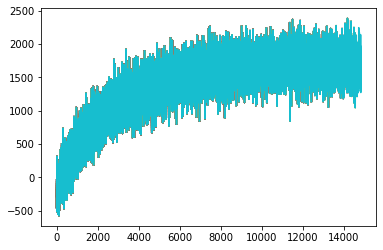

In [14]:
scores, episodes = [], []
state = env.state_init
state_encoded = env.state_encod_arch1(state)
state_size = len(state_encoded)
action_size = len(env.action_space)
agent = DQNAgent(state_size, action_size)

start_time = time.time()

for episode in range(Episodes):

    # Write code here
    # Call the environment
    # Call all the initialised variables of the environment
    
    terminal_state = False
    score = 0
    reward = 0
    total_days = 1
    previous_day = 0
    current_day = 0
    env.reset()
    state = env.state_init    

    #Call the DQN agent
    
    while not terminal_state:
        # 1. Pick epsilon-greedy action from possible actions for the current state
        # 2. Evaluate your reward and next state
        # 3. Append the experience to the memory
        # 4. Train the model by calling function agent.train_model
        # 5. Keep a track of rewards, Q-values, loss
        state_encoded = env.state_encod_arch1(state)
        state_encoded = np.reshape(state_encoded, [1, state_size])
        
        # get possible list of actions from the environment
        possible_actions, action_list = env.requests(state)
        
        action, q_val = agent.get_action(state_encoded, possible_actions)
        
        reward = env.reward_func(state, env.action_space[action], Time_matrix)
        next_state = env.next_state_func(state, env.action_space[action], Time_matrix)
        next_state_encoded = env.state_encod_arch1(next_state)
        next_state_encoded = np.reshape(next_state_encoded, [1, state_size])
        
        agent.append_sample(state_encoded, action, reward, next_state_encoded, terminal_state)
        #print("STATE:", state)
        add_to_dict(state, q_val, env.action_space[action], episode)
        
        agent.train_model()
        
        score += reward
        previous_day = state[2]
        state = next_state
        current_day = state[2]
        if previous_day != current_day:
            total_days = total_days + 1
            
        if total_days > NO_DAYS_PER_EPISODE:
            terminal_state = True
            
        if terminal_state == True:
            agent.update_target_model()
            scores.append(score)
            episodes.append(episode)
    
    epsilons.append(agent.epsilon)
    print("Episode:", episode, "  score:", score, "  memory length:", len(agent.memory), "  epsilon:", agent.epsilon)
    
    track_state_encode = Q_state(next_state)
    track_state_encoded = env.state_encod_arch1(next_state)
    track_state_encoded = np.reshape(track_state_encoded, [1, state_size])
    track_q_values = agent.get_q_values(track_state_encoded)
    
    if ((episode+1)%threshold)==0:
        save_tracking_states()
        save_obj(States_track,'States_tracked')

    
    # plot episode versus score 
    if episode % threshold == 0: 
        pylab.plot(episodes, scores)
        pylab.savefig("./" + directory_model + "/cardriver_dqn_" + str(score) + ".png")    
    
    #save the model 
    if episode % policy_threshold == 0:         
        # Model binary h5 file
        agent.save("./" + directory_model + "/cardriver_dqn_" + str(score) + ".h5")
        
        # Model pickle file
        save_obj(agent.get_model_weights(), "./" + directory_model + "/cardriver_dqn_" + str(score))
    
    #SAVING POLICY
    if ((episode+1)% policy_threshold ) == 0:  #every policy_threshold episodes, the Q-dict will be saved
        save_obj(Q_dict,'Policy')

elapsed_time = time.time() - start_time
save_obj(States_track,'States_tracked')   
save_obj(Q_dict,'Policy')
print("Timetaken:%d mins %d seconds"%(elapsed_time/60,elapsed_time%60))

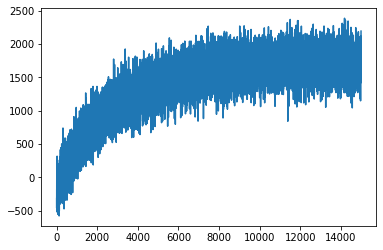

In [15]:
# convergence with scores
plt.plot(episodes, scores)

### Tracking Convergence

In [16]:
#Printing all keys in QDict
for key in Q_dict.keys():
    print("STATE",key,"\tactions: ", len(Q_dict[key]))

STATE 000406 	actions:  20
STATE 001606 	actions:  21
STATE 020000 	actions:  20
STATE 020100 	actions:  20
STATE 020200 	actions:  20
STATE 030800 	actions:  20
STATE 012000 	actions:  20
STATE 020-401 	actions:  20
STATE 000-201 	actions:  20
STATE 000-101 	actions:  20
STATE 000001 	actions:  20
STATE 000101 	actions:  20
STATE 020201 	actions:  20
STATE 020301 	actions:  20
STATE 020401 	actions:  20
STATE 020501 	actions:  20
STATE 041201 	actions:  20
STATE 001301 	actions:  20
STATE 001401 	actions:  20
STATE 001501 	actions:  20
STATE 021801 	actions:  20
STATE 010-502 	actions:  20
STATE 000-202 	actions:  21
STATE 020402 	actions:  20
STATE 020502 	actions:  20
STATE 020602 	actions:  20
STATE 020702 	actions:  20
STATE 021302 	actions:  20
STATE 021402 	actions:  20
STATE 041502 	actions:  20
STATE 031602 	actions:  20
STATE 021802 	actions:  20
STATE 021902 	actions:  20
STATE 022002 	actions:  20
STATE 020-1003 	actions:  19
STATE 020-903 	actions:  20
STATE 020-803 	actio

STATE 032000 	actions:  20
STATE 040-1102 	actions:  17
STATE 030-702 	actions:  20
STATE 021303 	actions:  20
STATE 031205 	actions:  20
STATE 040-206 	actions:  20
STATE 020-701 	actions:  20
STATE 020-1004 	actions:  16
STATE 030-804 	actions:  20
STATE 011505 	actions:  20
STATE 031202 	actions:  20
STATE 030803 	actions:  20
STATE 020700 	actions:  21
STATE 001400 	actions:  20
STATE 001500 	actions:  20
STATE 010303 	actions:  20
STATE 020-704 	actions:  20
STATE 020-604 	actions:  20
STATE 040504 	actions:  20
STATE 021905 	actions:  20
STATE 010300 	actions:  20
STATE 010401 	actions:  20
STATE 040002 	actions:  20
STATE 001002 	actions:  20
STATE 022102 	actions:  20
STATE 030505 	actions:  20
STATE 030-903 	actions:  19
STATE 030-605 	actions:  20
STATE 012102 	actions:  20
STATE 030-803 	actions:  20
STATE 030603 	actions:  20
STATE 010005 	actions:  20
STATE 010801 	actions:  20
STATE 040-202 	actions:  20
STATE 010-803 	actions:  20
STATE 010-703 	actions:  20
STATE 011403

In [17]:
print("All actions taken from state 031406 : {}\n".format(Q_dict["031406"].keys()))

print("All Q-values for action (3, 2) :  (EpisodeID, Q-value)")
if (3, 2) in Q_dict["031406"]:
    print(Q_dict["031406"][(3, 2)])

All actions taken from state 031406 : dict_keys([(0, 0), (4, 2), (0, 3), (4, 0), (0, 4), (0, 2), (3, 0), (1, 0), (2, 1), (3, 4), (4, 1), (3, 1), (2, 4), (1, 2), (1, 4), (3, 2), (4, 3), (2, 3), (2, 0), (1, 3)])

All Q-values for action (3, 2) :  (EpisodeID, Q-value)
[(214, 287.97784), (226, 298.59854), (242, 294.19666), (306, 286.57166), (325, 294.78134), (511, 303.0469), (692, 306.86057), (711, 311.80548), (741, 291.66577), (774, 316.12134), (788, 316.07394), (872, 321.53207), (884, 312.18015), (892, 304.7528), (896, 296.8696), (920, 306.14038), (940, 309.49133), (957, 306.36337), (1019, 307.37082), (1022, 311.41766), (1169, 309.03983), (1175, 317.64258), (1208, 312.16507), (1208, 306.85605), (1245, 315.11185), (1270, 308.91583), (1295, 305.96664), (1312, 301.37866), (1354, 316.27148), (1357, 310.47528), (1379, 309.29788), (1401, 311.90906), (1410, 318.58975), (1460, 302.64944), (1464, 301.86993), (1519, 314.15463), (1637, 320.18387), (1639, 315.35864), (1725, 318.74524), (1728, 312.23

In [18]:
#states tracked dictionary
States_track

defaultdict(dict,
            {'031406': {(3,
               2): [[(214, 287.97784),
                (226, 298.59854),
                (242, 294.19666),
                (306, 286.57166),
                (325, 294.78134),
                (511, 303.0469),
                (692, 306.86057),
                (711, 311.80548),
                (741, 291.66577),
                (774, 316.12134),
                (788, 316.07394),
                (872, 321.53207),
                (884, 312.18015),
                (892, 304.7528),
                (896, 296.8696),
                (920, 306.14038),
                (940, 309.49133),
                (957, 306.36337),
                (1019, 307.37082),
                (1022, 311.41766),
                (1169, 309.03983),
                (1175, 317.64258),
                (1208, 312.16507),
                (1208, 306.85605),
                (1245, 315.11185),
                (1270, 308.91583),
                (1295, 305.96664),
                (1312, 30

In [19]:
#states tracked
States_track.keys()

dict_keys(['031406', '021503', '030800', '001100'])

[(214, 287.97784), (226, 298.59854), (242, 294.19666), (306, 286.57166), (325, 294.78134), (511, 303.0469), (692, 306.86057), (711, 311.80548), (741, 291.66577), (774, 316.12134), (788, 316.07394), (872, 321.53207), (884, 312.18015), (892, 304.7528), (896, 296.8696), (920, 306.14038), (940, 309.49133), (957, 306.36337), (1019, 307.37082), (1022, 311.41766), (1169, 309.03983), (1175, 317.64258), (1208, 312.16507), (1208, 306.85605), (1245, 315.11185), (1270, 308.91583), (1295, 305.96664), (1312, 301.37866), (1354, 316.27148), (1357, 310.47528), (1379, 309.29788), (1401, 311.90906), (1410, 318.58975), (1460, 302.64944), (1464, 301.86993), (1519, 314.15463), (1637, 320.18387), (1639, 315.35864), (1725, 318.74524), (1728, 312.23007), (1734, 305.46643), (1752, 321.5429), (1833, 317.6308), (1886, 309.90787), (1894, 316.15414), (1899, 310.35968), (1901, 305.52145), (1920, 312.18637), (1973, 309.3866), (1994, 303.54834), (2022, 305.28177), (2036, 309.40967), (2053, 304.21875), (2063, 307.15143

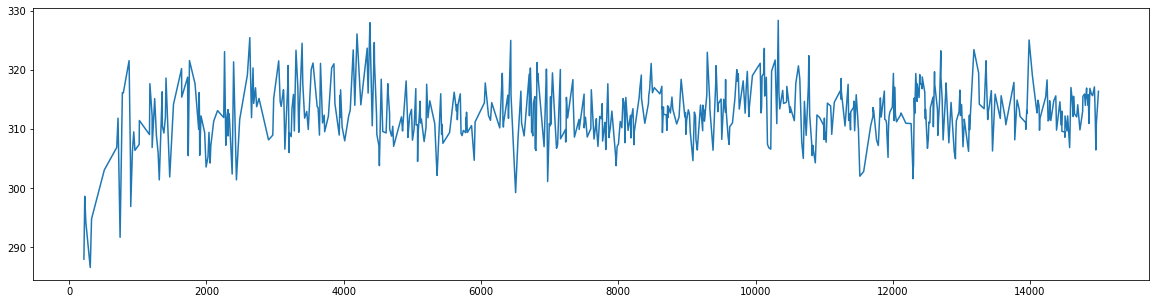

In [20]:
#plotting first state tracked convergence
plt.figure(0, figsize=(20,5))
if len(States_track["031406"][(3, 2)]) != 0:
    print(States_track["031406"][(3, 2)][0])
    key1 = list(States_track.keys())[0]
    key2 = list(States_track[key1].keys())[0]
    x,y = zip(*np.asarray(States_track[key1][key2][0]))
    plt.plot(x,y)

[(4, 71.944664), (69, 247.29593), (106, 253.79393), (136, 261.03058), (155, 279.78433), (173, 274.25873), (317, 283.95505), (338, 314.31778), (348, 290.36288), (353, 286.91495), (648, 304.02707), (693, 312.5894), (719, 305.29822), (764, 303.8056), (812, 303.78598), (846, 313.11325), (895, 292.68503), (896, 295.41928), (904, 288.11432), (971, 293.03003), (974, 299.3945), (978, 297.7107), (1055, 300.6369), (1116, 300.38846), (1128, 298.48035), (1153, 299.26996), (1154, 302.37048), (1265, 305.86694), (1305, 295.6048), (1363, 292.91772), (1446, 294.89813), (1471, 298.43723), (1484, 306.91827), (1499, 302.17682), (1631, 306.65662), (1700, 295.2383), (1838, 305.56696), (1861, 299.9699), (1880, 303.65512), (1927, 300.49628), (1979, 287.99585), (2011, 297.29196), (2029, 292.82877), (2060, 292.76697), (2195, 287.03397), (2274, 312.6256), (2313, 300.7827), (2327, 298.3511), (2333, 305.02637), (2425, 303.47827), (2454, 310.99973), (2517, 306.16742), (2658, 291.8755), (2666, 305.08295), (2667, 306

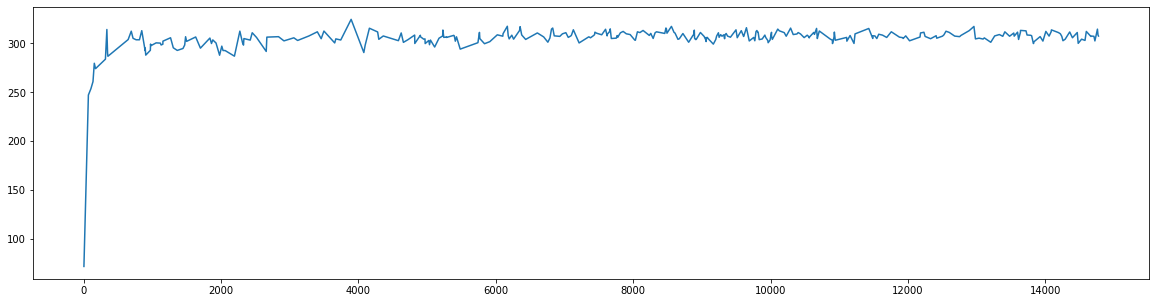

In [21]:
#plotting second state tracked convergence
plt.figure(0, figsize=(20,5))
if len(States_track["021503"][(4, 3)]) != 0:
    print(States_track["021503"][(4, 3)][0])
    key1 = list(States_track.keys())[1]
    key2 = list(States_track[key1].keys())[0]
    x,y = zip(*np.asarray(States_track[key1][key2][0]))
    plt.plot(x,y)

[(55, 219.98845), (345, 293.70532), (473, 283.14337), (513, 283.98767), (575, 283.44757), (603, 281.5515), (631, 266.41037), (687, 279.32474), (786, 277.79523), (831, 287.6322), (835, 290.4594), (897, 264.85245), (1005, 275.27377), (1044, 283.4876), (1069, 279.8776), (1103, 274.0518), (1251, 296.6585), (1337, 281.91187), (1360, 279.06854), (1668, 285.8718), (1750, 287.47778), (1857, 284.19852), (1870, 272.639), (2058, 278.63107), (2122, 284.38486), (2300, 273.91568), (2513, 292.56345), (2617, 284.7648), (2808, 282.68896), (2957, 280.80234), (3054, 282.82568), (3384, 305.51654), (3444, 287.1312), (3448, 286.2917), (3469, 293.6904), (3501, 300.39612), (3539, 295.08838), (3590, 291.95633), (3622, 281.6873), (3694, 287.03696), (3721, 276.8369), (3723, 279.25357), (3739, 279.9782), (3822, 284.26196), (3951, 287.5069), (3952, 286.22562), (4068, 285.5877), (4223, 281.19327), (4269, 282.5212), (4270, 282.93405), (4308, 281.69357), (4375, 285.67334), (4433, 288.54596), (4530, 277.99414), (4622,

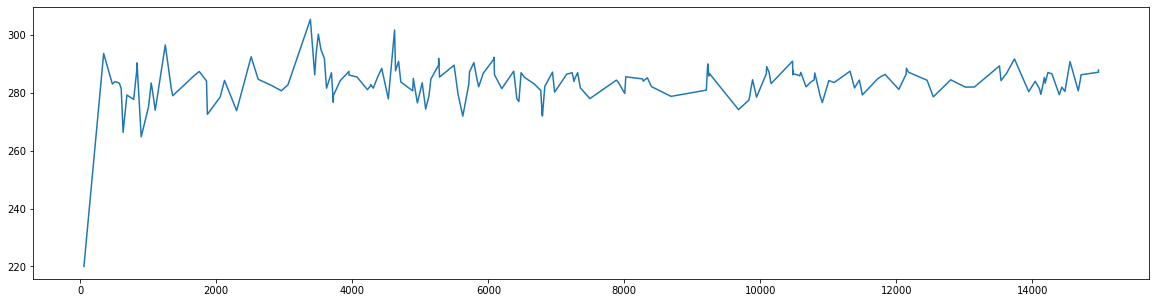

In [22]:
#plotting third state tracked convergence
plt.figure(0, figsize=(20,5))
if len(States_track["030800"][(3, 0)]) != 0:
    print(States_track["030800"][(3, 0)][0])
    key1 = list(States_track.keys())[2]
    key2 = list(States_track[key1].keys())[0]
    x,y = zip(*np.asarray(States_track[key1][key2][0]))
    plt.plot(x,y)

[(248, 254.30658), (274, 273.57266), (466, 288.46497), (475, 296.75693), (542, 303.69025), (594, 303.9032), (693, 285.0349), (706, 293.23627), (1044, 298.51077), (1217, 286.42773), (1227, 297.52448), (1251, 299.39178), (1281, 275.3018), (1305, 273.44482), (1486, 281.18228), (1610, 289.1706), (1664, 289.8532), (1724, 295.39426), (1737, 304.73993), (1750, 298.8295), (1863, 288.89127), (2046, 288.8433), (2128, 284.85724), (2293, 288.9831), (2301, 291.69733), (2320, 288.2312), (2343, 296.57178), (2391, 281.9688), (2499, 293.6635), (2521, 292.75323), (2530, 293.1624), (2607, 292.87933), (2708, 292.35675), (2804, 285.61044), (2826, 293.3334), (2839, 292.2021), (2882, 287.24347), (3301, 290.1001), (3312, 300.59494), (3375, 285.63278), (3444, 297.25665), (3554, 306.58072), (3590, 297.39478), (3622, 289.23502), (3684, 295.8647), (3801, 292.4569), (4068, 299.83102), (4099, 293.91577), (4375, 294.32782), (4415, 282.9802), (4441, 298.39084), (4475, 285.66907), (4534, 276.72964), (4565, 287.1783), 

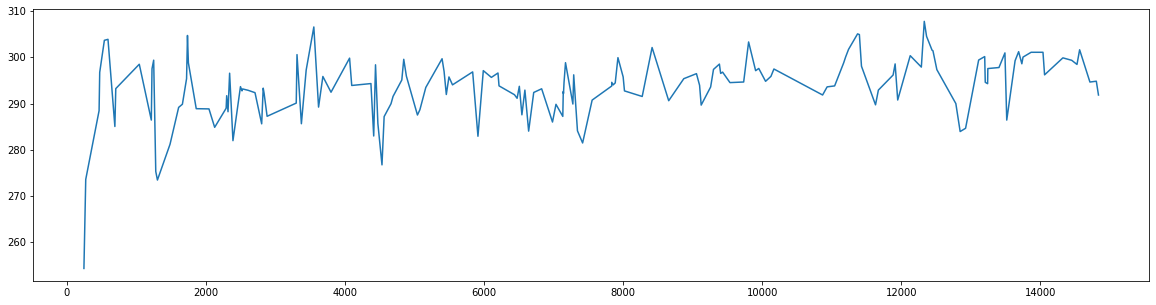

In [23]:
#plotting fourth state tracked convergence
plt.figure(0, figsize=(20,5))
if len(States_track["001100"][(4, 3)]) != 0:
    print(States_track["001100"][(4, 3)][0])
    key1 = list(States_track.keys())[3]
    key2 = list(States_track[key1].keys())[0]
    x,y = zip(*np.asarray(States_track[key1][key2][0]))
    plt.plot(x,y)

#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

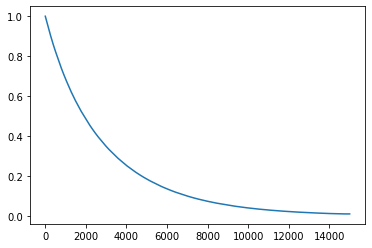

In [24]:
#Using epsilons tracked over all episodes
plt.plot(episodes, epsilons)
plt.show()